<h2 align="center"><span style="font-family: Babas; font-size: 2em;">Automative Regression Analysis For Linktera</span></h2>
<h4 align="center"><span style="font-family: Babas; font-size: 1.5em; font-style: italic">This Notebook Includes EDA, Feature Engineering and Multilinear Regression Model</span></h4>
<h4 align="center"><span style="font-family: Babas; font-size: 1.5em;">By Gökalp Eren Akol</span></h4>





<h5 align="center"><span style="font-family: Babas; font-size: 1.5em;">Initially, in this project, independent variables (ÖTV,Faiz, Kredi Stok and EUR) were populated with real data. However, due to project requirements, this data should not be used. The real data was used to compare the accuracy of the predictions to be made.</span></h5>


<h5 align="center"><span style="font-family: Babas; font-size: 1.5em;">The independent variables EUR, Faiz, Kredi Stok, and ÖTV were predicted using the Prophet model, respectively. The predicted independent variables were used in the final modeling stage. </span></h5>









### Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px


import joblib

from prophet import Prophet


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import optuna

import os

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

In [7]:
data_path = "data\Veri-Seti.xlsx"
df = pd.read_excel(data_path)

print(f"Boyut: {df.shape}")
print(f"Sütunlar: {list(df.columns)}")
print(f"Tarih aralığı: {df['Date'].min()} - {df['Date'].max()}")
print(f"Eksik değerler: {df.isnull().sum().sum()}")


df.head()

Boyut: (162, 6)
Sütunlar: ['Date', 'Otomotiv Satis', 'OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']
Tarih aralığı: 2010-01-01 00:00:00 - 2023-06-01 00:00:00
Eksik değerler: 65


,Date,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok
0,2010-01-01,"20,095.0000",37.0000,13.1820,2.1074,"341,244.1260"
1,2010-02-01,"31,172.0000",37.0000,13.2725,2.0739,"351,940.9490"
2,2010-03-01,"51,769.0000",37.0000,12.7275,2.0855,"361,307.3200"
3,2010-04-01,"54,946.0000",37.0000,12.0120,2.0090,"373,575.3400"
4,2010-05-01,"59,377.0000",37.0000,11.7400,1.9489,"387,708.0510"


#### Filling the missing values with bfill method in order to get an starting idea

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df_clean = df.ffill().bfill()

print(f"Cleaned data shape: {df_clean.shape}")
print(f"Any missing values left: {df_clean.isnull().sum().sum()}")

target = 'Otomotiv Satis'
print(f"\nTarget variable: {target}")
print(f"Mean: {df_clean[target].mean():.0f}")
print(f"Standard deviation: {df_clean[target].std():.0f}")

df_clean.head()

Cleaned data shape: (162, 5)
Any missing values left: 0

Target variable: Otomotiv Satis
Mean: 65844
Standard deviation: 25098


,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok
Date,,,,,
2010-01-01,"20,095.0000",37.0000,13.1820,2.1074,"341,244.1260"
2010-02-01,"31,172.0000",37.0000,13.2725,2.0739,"351,940.9490"
2010-03-01,"51,769.0000",37.0000,12.7275,2.0855,"361,307.3200"
2010-04-01,"54,946.0000",37.0000,12.0120,2.0090,"373,575.3400"
2010-05-01,"59,377.0000",37.0000,11.7400,1.9489,"387,708.0510"


# Part 1 (Filling Values With Real Data) Just For Analysis

Here we fill the values with real data from EVDS. Since the project requirements changed after this stage, I left this part as is. We will not use these values in the model, they are kept only for visualization purposes.

Part 1 covers general data analysis, detection of missing values, and the imputation of EUR/TRY and Faiz values after 2022-06. 

## EDA 1(EVDS)




### Plot Analysis

Notes:
2018-2019 Decrease in sales

December Periodic Max sales

We can Create Dummy Variables for them later.

C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\3571748919.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(monthly_data, labels=['Jan','Feb','Mar','Apr','May','Jun',


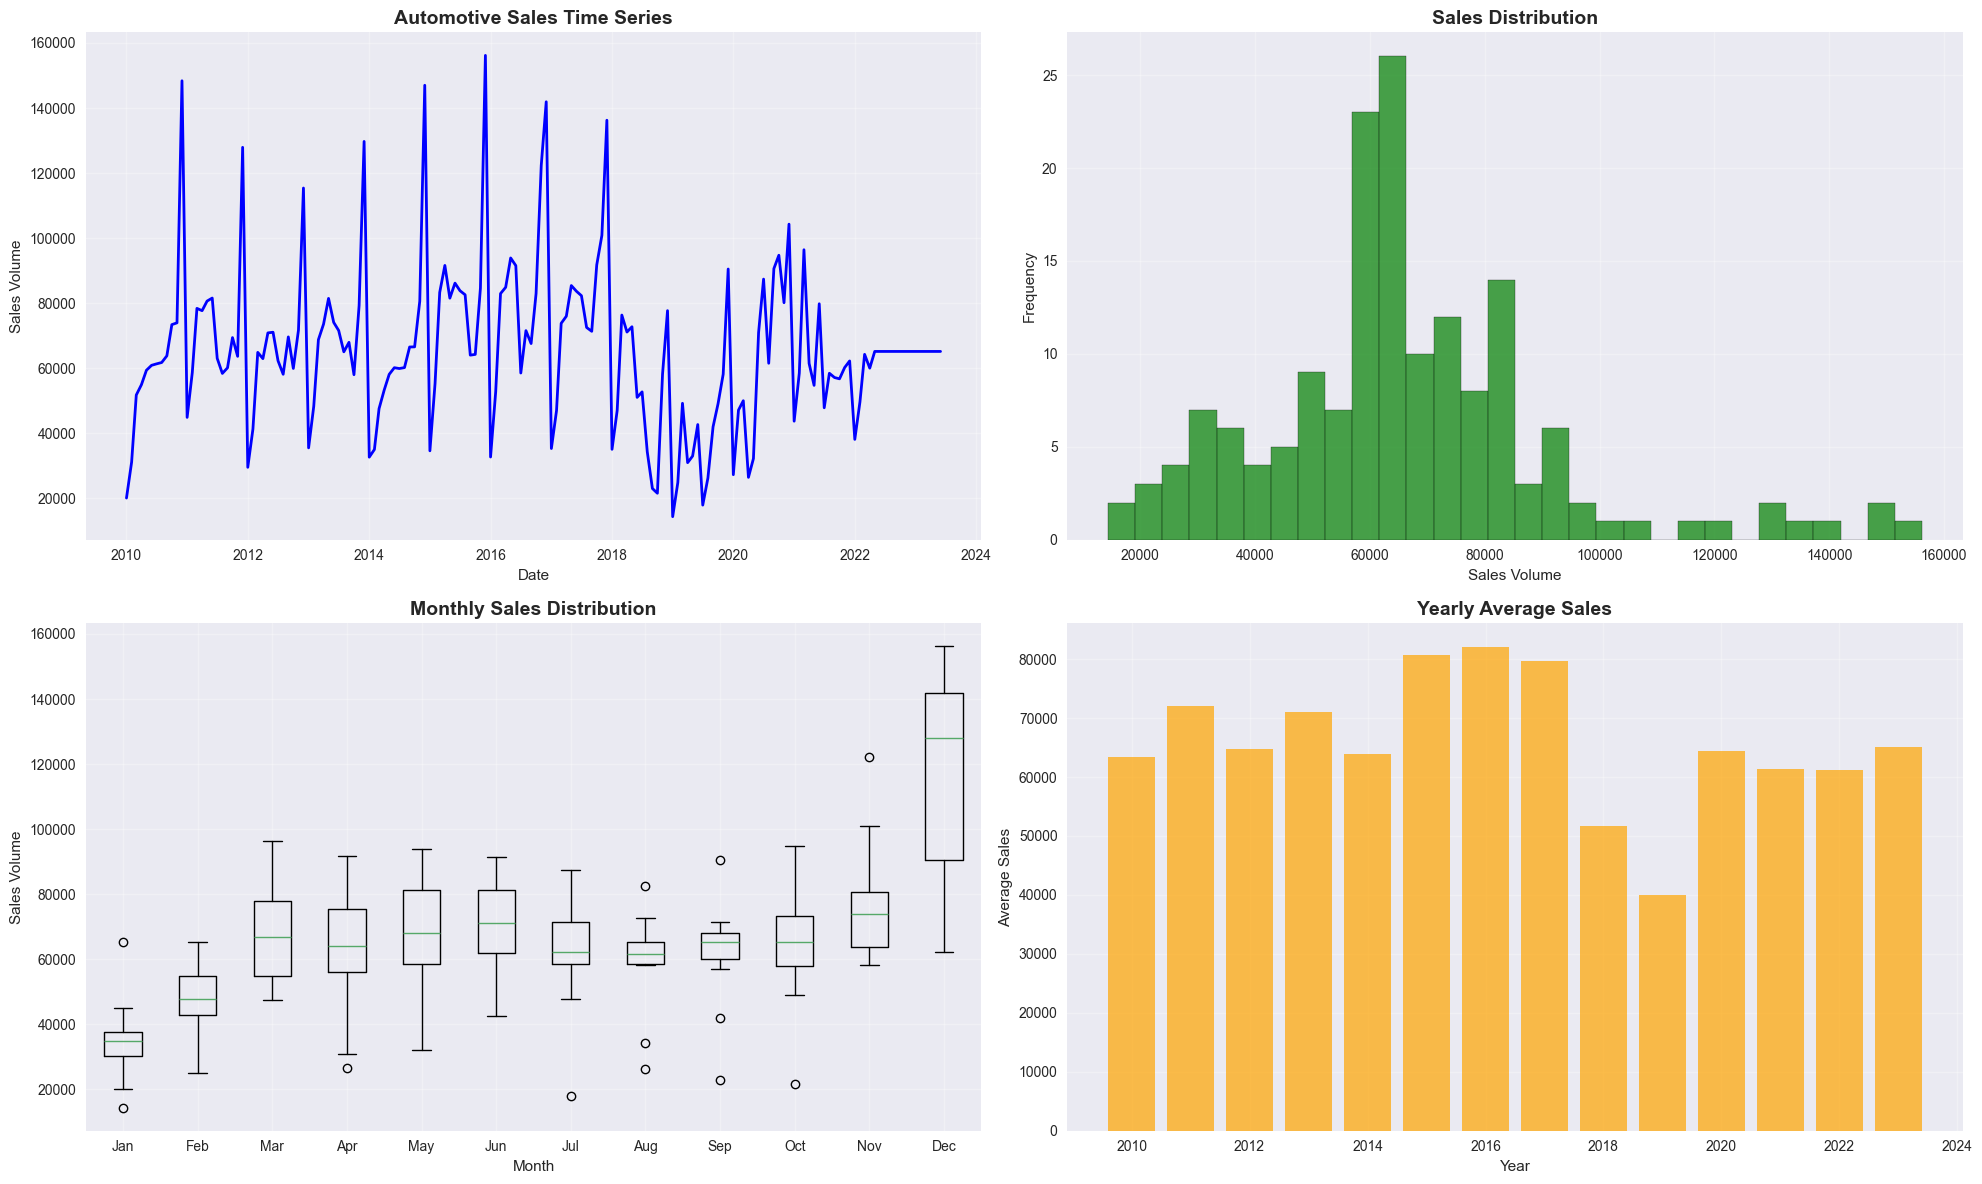

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

axes[0,0].plot(df_clean.index, df_clean[target], linewidth=2, color='blue')
axes[0,0].set_title('Automotive Sales Time Series', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Sales Volume')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(df_clean[target], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_title('Sales Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Sales Volume')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

df_clean['Month'] = df_clean.index.month
monthly_data = [df_clean[df_clean['Month'] == i][target].values for i in range(1, 13)]
axes[1,0].boxplot(monthly_data, labels=['Jan','Feb','Mar','Apr','May','Jun',
                                       'Jul','Aug','Sep','Oct','Nov','Dec'])
axes[1,0].set_title('Monthly Sales Distribution', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Sales Volume')
axes[1,0].grid(True, alpha=0.3)

yearly_avg = df_clean.groupby(df_clean.index.year)[target].mean()
axes[1,1].bar(yearly_avg.index, yearly_avg.values, color='orange', alpha=0.7)
axes[1,1].set_title('Yearly Average Sales', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Average Sales')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Decomposition

The decomposition shows a clear yearly seasonality in automotive sales, with recurring peaks and troughs.
The long-term trend reflects economic cycles, with a downturn around 2018 and a recovery afterward.
Residuals capture irregular shocks, indicating extraordinary events not explained by trend or seasonality.

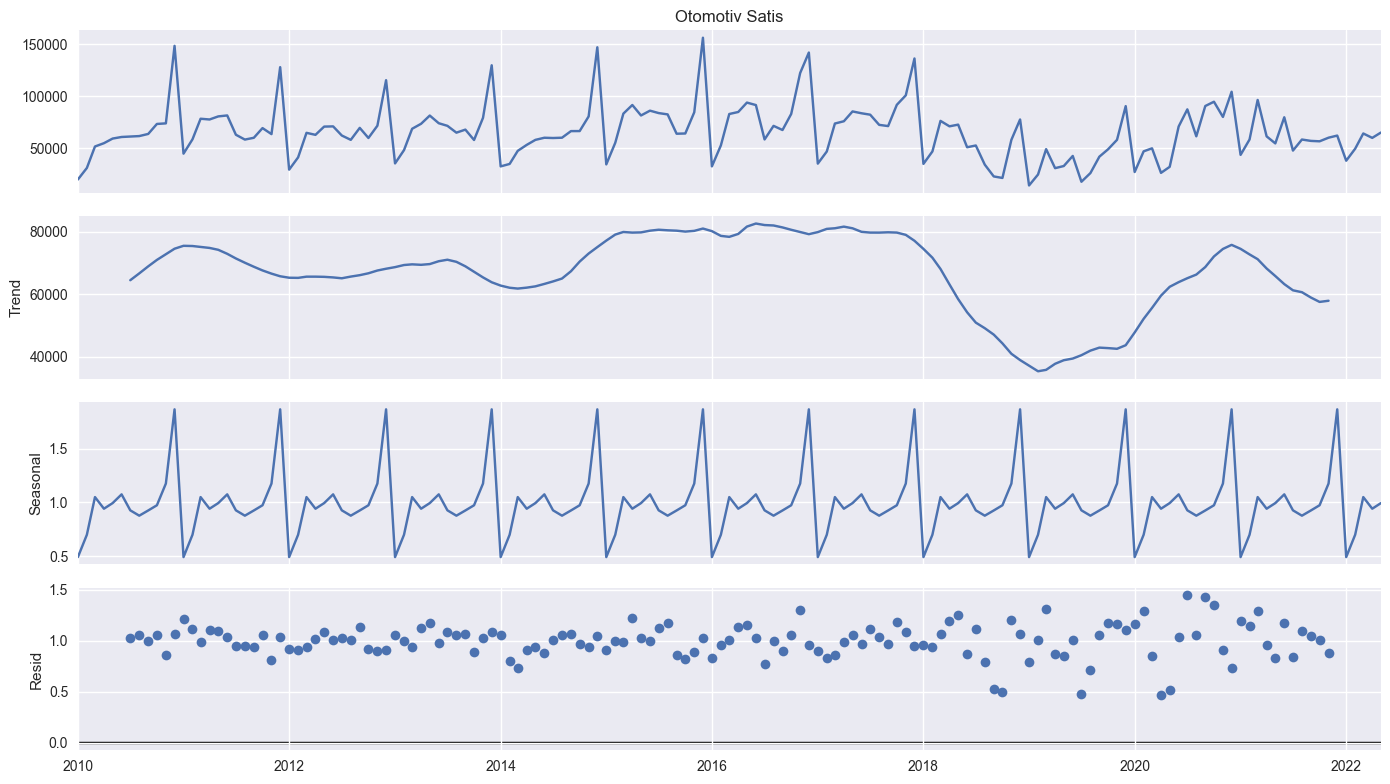

In [10]:
train_data = pd.read_csv(r"D:\GIT\Linktera\final_notebook\data\final_data\train.csv")
train_data["Date"] = pd.to_datetime(train_data["Date"])
train_data = train_data.set_index("Date")


target_series = train_data["Otomotiv Satis"]


decomposition = seasonal_decompose(target_series, model="multiplicative", period=12)  # aylık veri, 12 ay döngü


decomp_fig = decomposition.plot()
decomp_fig.set_size_inches(14, 8)
plt.show()


trend_component = decomposition.trend
seasonal_component = decomposition.seasonal
residual_component = decomposition.resid

### Missing Values Analysis (EVDS)

In here, the missing values are starting after 2022-06 which we will use them as a test data.

In [11]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percent': missing_percent.values
})

print("Missing value summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

print(f"\nA total of {df.isnull().any(axis=1).sum()} rows have missing values")

if df.isnull().any().any():
    print("\nTime distribution of missing values:")
    missing_dates = df[df.isnull().any(axis=1)].index
    print(f"First missing value: {missing_dates.min()}")
    print(f"Last missing value: {missing_dates.max()}")
    print(f"Missing value span: {len(missing_dates)} months")


Missing value summary:
           Column  Missing_Count  Missing_Percent
0  Otomotiv Satis             13           8.0247
1       OTV Orani             13           8.0247
2            Faiz             13           8.0247
3          EUR/TL             13           8.0247
4      Kredi Stok             13           8.0247

A total of 13 rows have missing values

Time distribution of missing values:
First missing value: 2022-06-01 00:00:00
Last missing value: 2023-06-01 00:00:00
Missing value span: 13 months


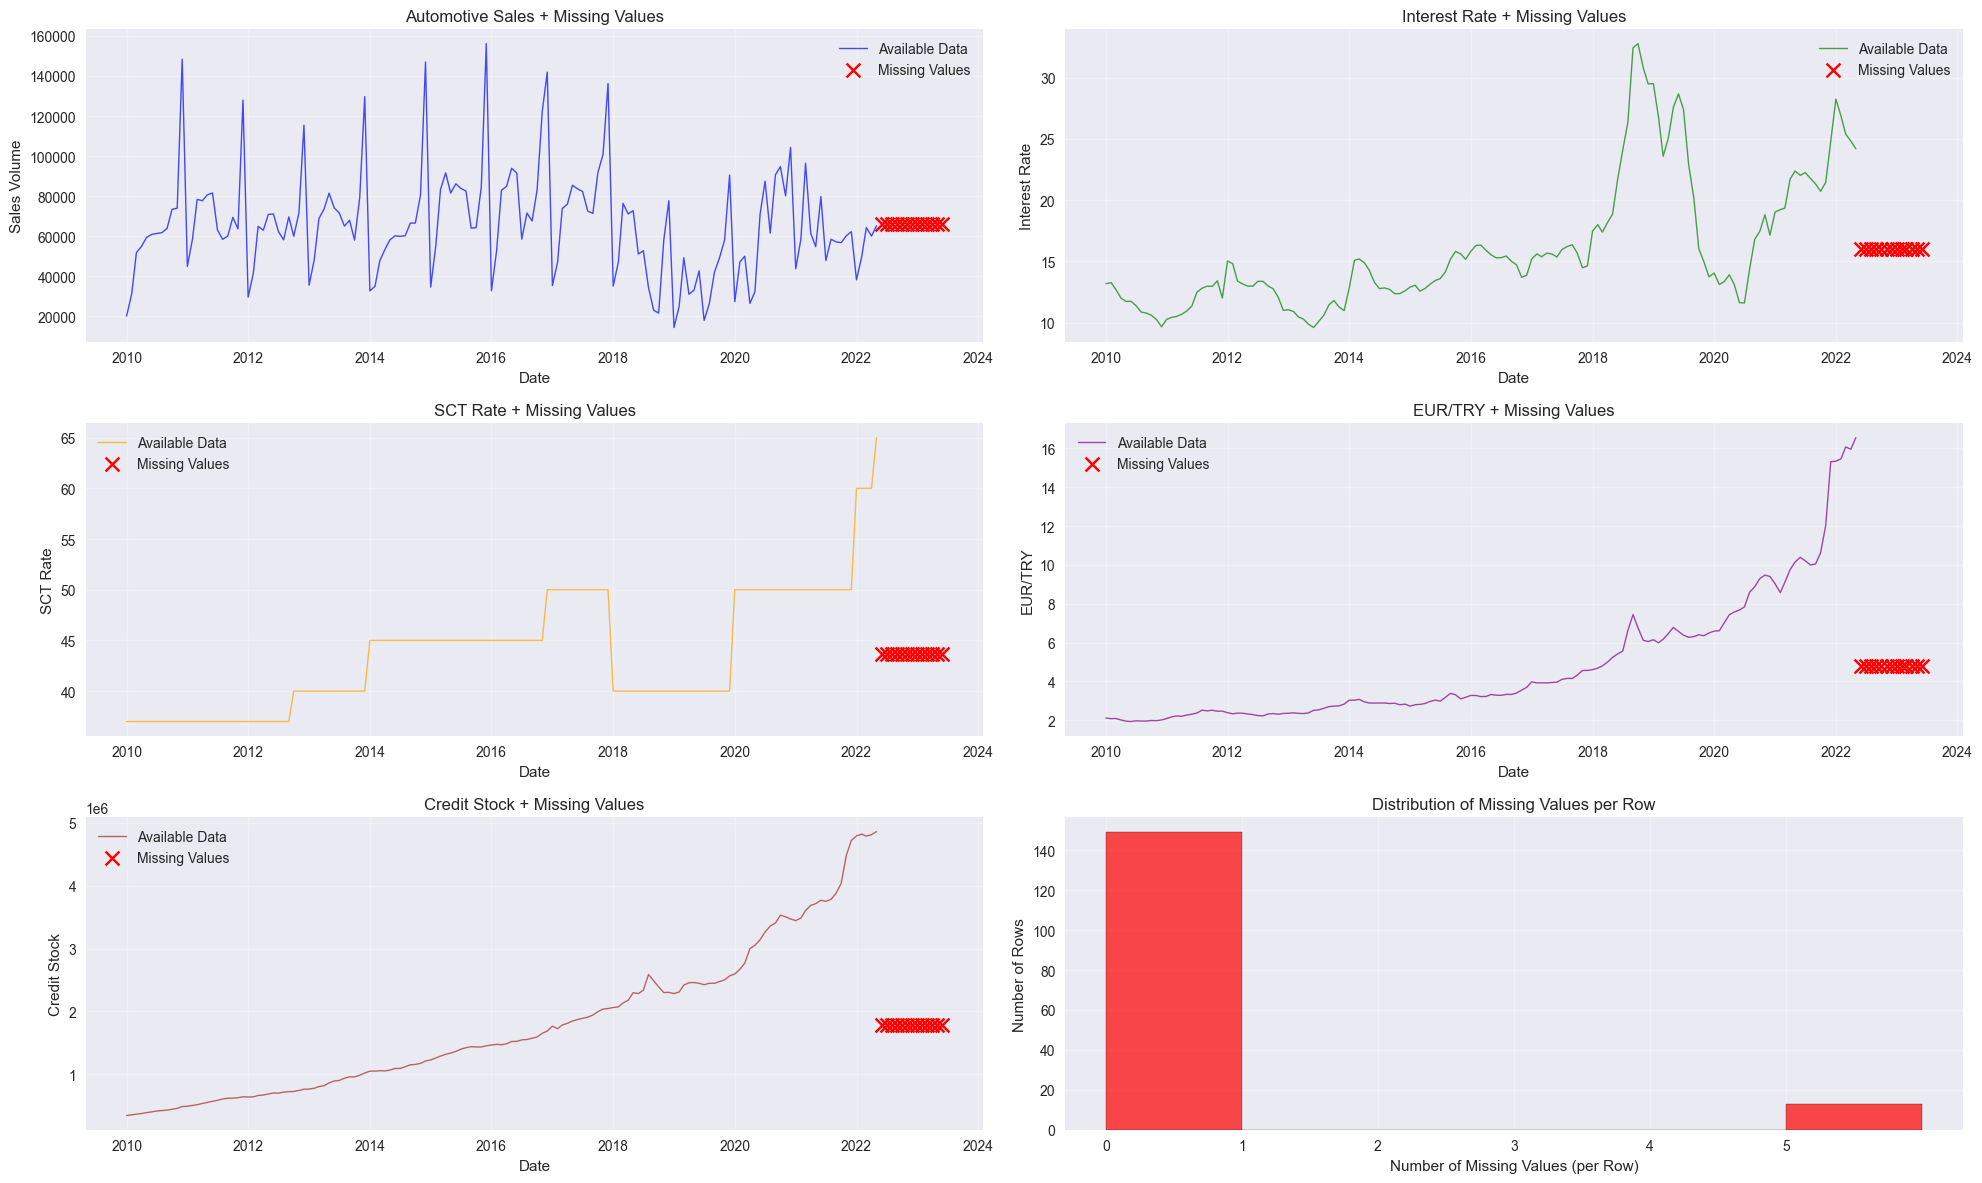

In [12]:
plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
plt.plot(df.index, df['Otomotiv Satis'], 'b-', linewidth=1, alpha=0.7, label='Available Data')
missing_sales = df[df['Otomotiv Satis'].isnull()]
if not missing_sales.empty:
    plt.scatter(missing_sales.index, [df['Otomotiv Satis'].mean()]*len(missing_sales), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('Automotive Sales + Missing Values')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 2)
plt.plot(df.index, df['Faiz'], 'g-', linewidth=1, alpha=0.7, label='Available Data')
missing_faiz = df[df['Faiz'].isnull()]
if not missing_faiz.empty:
    plt.scatter(missing_faiz.index, [df['Faiz'].mean()]*len(missing_faiz), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('Interest Rate + Missing Values')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 3)
plt.plot(df.index, df['OTV Orani'], 'orange', linewidth=1, alpha=0.7, label='Available Data')
missing_otv = df[df['OTV Orani'].isnull()]
if not missing_otv.empty:
    plt.scatter(missing_otv.index, [df['OTV Orani'].mean()]*len(missing_otv), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('SCT Rate + Missing Values')
plt.xlabel('Date')
plt.ylabel('SCT Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 4)
plt.plot(df.index, df['EUR/TL'], 'purple', linewidth=1, alpha=0.7, label='Available Data')
missing_eur = df[df['EUR/TL'].isnull()]
if not missing_eur.empty:
    plt.scatter(missing_eur.index, [df['EUR/TL'].mean()]*len(missing_eur), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('EUR/TRY + Missing Values')
plt.xlabel('Date')
plt.ylabel('EUR/TRY')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 5)
plt.plot(df.index, df['Kredi Stok'], 'brown', linewidth=1, alpha=0.7, label='Available Data')
missing_kredi = df[df['Kredi Stok'].isnull()]
if not missing_kredi.empty:
    plt.scatter(missing_kredi.index, [df['Kredi Stok'].mean()]*len(missing_kredi), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('Credit Stock + Missing Values')
plt.xlabel('Date')
plt.ylabel('Credit Stock')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 6)
missing_by_row = df.isnull().sum(axis=1)
plt.hist(missing_by_row, bins=range(0, 7), alpha=0.7, color='red', edgecolor='black')
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values (per Row)')
plt.ylabel('Number of Rows')
plt.xticks(range(0, 6))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### EUR/TRY Fill (EVDS)

After reviewing the EUR/TRY values, I observed that they are consistent with real-world data and are not artificial. We will fill these values using a financial API.


In [13]:
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])

print(f"Date column has been converted back to a regular column")
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date column type: {df['Date'].dtype}")
print(f"First date: {df['Date'].min()}")
print(f"Last date: {df['Date'].max()}")

print("\nFIRST 5 ROWS:")
df.head()

Date column has been converted back to a regular column
DataFrame shape: (162, 6)
Columns: ['Date', 'Otomotiv Satis', 'OTV Orani', 'Faiz', 'EUR/TL', 'Kredi Stok']
Date column type: datetime64[ns]
First date: 2010-01-01 00:00:00
Last date: 2023-06-01 00:00:00

FIRST 5 ROWS:


,Date,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok
0,2010-01-01,"20,095.0000",37.0000,13.1820,2.1074,"341,244.1260"
1,2010-02-01,"31,172.0000",37.0000,13.2725,2.0739,"351,940.9490"
2,2010-03-01,"51,769.0000",37.0000,12.7275,2.0855,"361,307.3200"
3,2010-04-01,"54,946.0000",37.0000,12.0120,2.0090,"373,575.3400"
4,2010-05-01,"59,377.0000",37.0000,11.7400,1.9489,"387,708.0510"


In [14]:
eurtry = yf.download("EURTRY=X", start="2010-01-01", end="2023-12-31", interval="1mo")

finance_df = pd.DataFrame(eurtry)

eurtry.head()

C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\2096516269.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eurtry = yf.download("EURTRY=X", start="2010-01-01", end="2023-12-31", interval="1mo")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,EURTRY=X,EURTRY=X,EURTRY=X,EURTRY=X,EURTRY=X
Date,,,,,
2010-01-01,2.0751,2.1475,2.0414,2.1408,0
2010-02-01,2.1119,2.1126,2.0192,2.0746,0
2010-03-01,2.0494,2.1150,2.0137,2.1126,0
2010-04-01,1.9727,2.0624,1.9577,2.0492,0
2010-05-01,1.9311,2.0406,1.8621,1.9327,0


In [15]:
eur_try = yf.download("EURTRY=X", start="2010-01-01", end="2011-12-31", interval="1mo")


eur_try.columns = [col[0] if isinstance(col, tuple) else col for col in eur_try.columns]
eur_try = eur_try[['Close']]  # sadece kapanış fiyatı
eur_try = eur_try.reset_index()  # Date kolonunu aç
eur_try['Date'] = pd.to_datetime(eur_try['Date'])

print(eur_try.head())


C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\679262640.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eur_try = yf.download("EURTRY=X", start="2010-01-01", end="2011-12-31", interval="1mo")
[*********************100%***********************]  1 of 1 completed

        Date  Close
0 2010-01-01 2.0751
1 2010-02-01 2.1119
2 2010-03-01 2.0494
3 2010-04-01 1.9727
4 2010-05-01 1.9311


In [16]:
df["Date"] = pd.to_datetime(df["Date"])
end_date = (df["Date"].max() + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")

eur_try = yf.download("EURTRY=X",
                      start=df["Date"].min().strftime("%Y-%m-%d"),
                      end=end_date,
                      interval="1mo")


eur_try.columns = [col[0] if isinstance(col, tuple) else col for col in eur_try.columns]
eur_try = eur_try[['Close']].reset_index()
eur_try['Date'] = pd.to_datetime(eur_try['Date'])


df_filled = df.merge(eur_try, on="Date", how="left")


df_filled["EUR/TL"] = df_filled["EUR/TL"].fillna(df_filled["Close"])


df_filled = df_filled.drop(columns=["Close"])

print(df_filled)

C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\2642926193.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eur_try = yf.download("EURTRY=X",
[*********************100%***********************]  1 of 1 completed

          Date  Otomotiv Satis  OTV Orani    Faiz  EUR/TL   Kredi Stok
0   2010-01-01     20,095.0000    37.0000 13.1820  2.1074 341,244.1260
1   2010-02-01     31,172.0000    37.0000 13.2725  2.0739 351,940.9490
2   2010-03-01     51,769.0000    37.0000 12.7275  2.0855 361,307.3200
3   2010-04-01     54,946.0000    37.0000 12.0120  2.0090 373,575.3400
4   2010-05-01     59,377.0000    37.0000 11.7400  1.9489 387,708.0510
..         ...             ...        ...     ...     ...          ...
157 2023-02-01             NaN        NaN     NaN 20.0335          NaN
158 2023-03-01             NaN        NaN     NaN 20.9096          NaN
159 2023-04-01             NaN        NaN     NaN 21.4365          NaN
160 2023-05-01             NaN        NaN     NaN 22.0913          NaN
161 2023-06-01             NaN        NaN     NaN 28.2484          NaN

[162 rows x 6 columns]


In [17]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['EUR/TL'],
    mode='lines+markers',
    name='Original (missing)',
    line=dict(color='red'),
    connectgaps=False
))

fig.add_trace(go.Scatter(
    x=df_filled['Date'],
    y=df_filled['EUR/TL'],
    mode='lines+markers',
    name='Filled',
    line=dict(color='blue')
))

fig.update_layout(
    title="Monthly EUR/TRY Rate - Original vs Filled",
    xaxis_title="Date",
    yaxis_title="EUR/TRY",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


In [18]:
output_path = "data\\filled_data\\eur_tl_filled.csv"
df_filled.to_csv(output_path, index=False, encoding="utf-8-sig")

### Faiz Fill (EVDS)


After reviewing the Faiz values, I observed that they are consistent with real world data and are not artificial. We will fill these values using a TCMB EVDS API.

If you dont have an EVDS API Key, reach me out so that i can help you.


In [19]:
fig = px.line(df, 
              x="Date", 
              y="Faiz", 
              title="Faiz Oranı (Our Data)",
              markers=True)

fig.update_traces(mode="lines+markers", hovertemplate="Tarih=%{x}<br>Faiz=%{y:.2f}")
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Faiz (%)",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


In [ ]:
from evds import evdsAPI
import pandas as pd


####If you dont have an EVDS API Key, reach me out so that i can help you.#####
API_KEY = "YOUR_API_KEY

evds = evdsAPI(API_KEY)


df_fx = evds.get_data(
    ['TP.DK.USD.A.YTL', 'TP.DK.EUR.A.YTL'],
    startdate="01-01-2019",
    enddate="01-01-2020"
)

print(df_fx.head())


        Tarih  TP_DK_USD_A_YTL  TP_DK_EUR_A_YTL
0  01-01-2019              NaN              NaN
1  02-01-2019           5.2810           6.0422
2  03-01-2019           5.3316           6.1061
3  04-01-2019           5.4588           6.2057
4  05-01-2019              NaN              NaN


In [21]:
faiz_df = evds.get_data(
    ['TP.KTF18'], 
    startdate="01-01-2010", 
    enddate="31-12-2023"
)

faiz_df["Tarih"] = pd.to_datetime(faiz_df["Tarih"], dayfirst=True)
faiz_df["Faiz_TCMB"] = faiz_df["TP_KTF18"].astype(float)


faiz_monthly = faiz_df.set_index("Tarih").resample("M").last().reset_index()
faiz_monthly["Date"] = faiz_monthly["Tarih"].dt.to_period("M").dt.to_timestamp()
faiz_monthly = faiz_monthly[["Date", "Faiz_TCMB"]]

print(faiz_monthly.head())


        Date  Faiz_TCMB
0 2010-01-01        NaN
1 2010-02-01        NaN
2 2010-03-01        NaN
3 2010-04-01        NaN
4 2010-05-01        NaN


C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\3116943079.py:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [22]:
compare = df[['Date', 'Faiz']].merge(
    faiz_monthly, on='Date', how='left'
)


#### `The TP.KTF18` data from EVDS shows a high correlation with our Faiz data. We will use this API to fill in the missing values in the test data.

In [23]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=compare["Date"], y=compare["Faiz"],
    mode="lines+markers",
    name="Our Interest Rate",
    line=dict(color="red")
))

fig.add_trace(go.Scatter(
    x=compare["Date"], y=compare["Faiz_TCMB"],
    mode="lines+markers",
    name="CBRT Policy Rate",
    line=dict(color="blue")
))

fig.update_layout(
    title="Our Faiz Oranı Data vs EVDS",
    xaxis_title="Date",
    yaxis_title="Interest Rate (%)",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


In [24]:
compare["Fark"] = compare["Faiz"] - compare["Faiz_TCMB"]


fig = px.line(compare, x="Date", y="Fark", 
              title="Bizim Faiz - TCMB Politika Faizi Farkı",
              labels={"Fark":"Fark (puan)"})
fig.add_hline(y=0, line_dash="dot", line_color="gray")
fig.show()


#### To find the data series with the highest correlation, I will compare different data codes and look for high correlation and similarity.

In [25]:
faizler = evds.get_data(
    ['TP.KTF17', 'TP.KTF18', 'TP.KTFTUK', 'TP.KTFTUK01'],
    startdate="01-01-2010",
    enddate="31-12-2023"
)


faizler["Tarih"] = pd.to_datetime(faizler["Tarih"], dayfirst=True)


for col in faizler.columns:
    if col != "Tarih":
        faizler[col] = pd.to_numeric(faizler[col], errors="coerce")


faizler_monthly = faizler.set_index("Tarih").resample("M").last().reset_index()
faizler_monthly["Date"] = faizler_monthly["Tarih"].dt.to_period("M").dt.to_timestamp()

print(faizler_monthly.head())


       Tarih  YEARWEEK  TP_KTF17  TP_KTF18  TP_KTFTUK  TP_KTFTUK01       Date
0 2010-01-31       NaN    9.5300       NaN    13.7600          NaN 2010-01-01
1 2010-02-28       NaN    8.9200       NaN    13.3600          NaN 2010-02-01
2 2010-03-31       NaN    8.8300       NaN    13.1000          NaN 2010-03-01
3 2010-04-30       NaN    9.2600       NaN    12.9600          NaN 2010-04-01
4 2010-05-31       NaN    9.2300       NaN    13.2500          NaN 2010-05-01


C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\3482449242.py:16: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [26]:
fig = go.Figure()

for col in ["TP_KTF17", "TP_KTF18", "TP_KTFTUK", "TP_KTFTUK01"]:
    fig.add_trace(go.Scatter(
        x=faizler_monthly["Date"], 
        y=faizler_monthly[col], 
        mode="lines", 
        name=col
    ))

fig.update_layout(
    title="Piyasa Faizleri (Ticari ve Tüketici Kredileri)",
    xaxis_title="Tarih",
    yaxis_title="Faiz (%)",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


In [27]:
faizler = evds.get_data(
    ['TP.KTF17', 'TP.KTF18', 'TP.KTFTUK', 'TP.KTFTUK01'],
    startdate="01-01-2010",
    enddate="31-12-2023"
)

faizler["Tarih"] = pd.to_datetime(faizler["Tarih"], dayfirst=True)
for col in faizler.columns:
    if col != "Tarih":
        faizler[col] = pd.to_numeric(faizler[col], errors="coerce")

faizler_monthly = faizler.set_index("Tarih").resample("M").last().reset_index()
faizler_monthly["Date"] = faizler_monthly["Tarih"].dt.to_period("M").dt.to_timestamp()


C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\2183617154.py:12: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [28]:
compare_all = df[["Date","Faiz"]].merge(faizler_monthly, on="Date", how="left")


In [29]:
results = {}
for col in ["TP_KTF17","TP_KTF18","TP_KTFTUK","TP_KTFTUK01"]:
    corr = compare_all[["Faiz", col]].corr().iloc[0,1]
    mae = (compare_all["Faiz"] - compare_all[col]).abs().mean()
    results[col] = {"corr": corr, "mae": mae}

results_df = pd.DataFrame(results).T
print(results_df)


              corr    mae
TP_KTF17    0.9347 1.5821
TP_KTF18    0.9335 2.1371
TP_KTFTUK   0.9659 1.3402
TP_KTFTUK01 0.6959 3.6836


In [30]:
missing = df[df["Faiz"].isnull()]
print("Missing Rows:", len(missing))
print(missing[["Date"]].head())


Missing Rows: 13
          Date
149 2022-06-01
150 2022-07-01
151 2022-08-01
152 2022-09-01
153 2022-10-01


In [31]:

df_filled = df.merge(
    faizler_monthly[["Date", "TP_KTFTUK"]],
    on="Date",
    how="left"
)


df_filled["Faiz"] = df_filled["Faiz"].fillna(df_filled["TP_KTFTUK"])


print("Filled Rows:", df["Faiz"].isnull().sum() - df_filled["Faiz"].isnull().sum())


Filled Rows: 13


In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["Date"], y=df["Faiz"],
    mode="lines+markers",
    name="Original Interest Rate (With Missing)",
    line=dict(color="red"),
    opacity=1
))

fig.add_trace(go.Scatter(
    x=df_filled["Date"], y=df_filled["Faiz"],
    mode="lines+markers",
    name="Filled Interest Rate (With TP_KTFTUK)",
    line=dict(color="green"),
    opacity=0.5
))

fig.update_layout(
    title="Original vs Filled Interest Rate Series",
    xaxis_title="Date",
    yaxis_title="Interest Rate (%)",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


In [33]:

df_evds = df.merge(
    faizler_monthly[["Date", "TP_KTFTUK"]],
    on="Date",
    how="left"
)
df_evds["Faiz"] = df_evds["Faiz"].fillna(df_evds["TP_KTFTUK"])
df_evds = df_evds.drop(columns=["TP_KTFTUK"])

end_date = (df["Date"].max() + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")
eur_try = yf.download("EURTRY=X",
                      start=df["Date"].min().strftime("%Y-%m-%d"),
                      end=end_date,
                      interval="1mo")

eur_try.columns = [col[0] if isinstance(col, tuple) else col for col in eur_try.columns]
eur_try = eur_try[['Close']].reset_index()
eur_try['Date'] = pd.to_datetime(eur_try['Date'])

df_final = df_evds.merge(eur_try, on="Date", how="left")
df_final["EUR/TL"] = df_final["EUR/TL"].fillna(df_final["Close"])
df_final = df_final.drop(columns=["Close"])

print("Remaining missing Faiz:", df_final["Faiz"].isnull().sum())
print("Remaining missing EUR/TL:", df_final["EUR/TL"].isnull().sum())


C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\1090649605.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

Remaining missing Faiz: 0
Remaining missing EUR/TL: 0


In [34]:
df_final.to_csv("data\\filled_data\\faiz_filled.csv", index=False, encoding="utf-8-sig")


In [35]:
faiz_df = pd.read_csv("data\\filled_data\\faiz_filled.csv", parse_dates=["Date"])
eur_df = pd.read_csv("data\\filled_data\\eur_tl_filled.csv", parse_dates=["Date"])


faiz_df["Date"] = pd.to_datetime(faiz_df["Date"])
eur_df["Date"] = pd.to_datetime(eur_df["Date"])

if "EUR/TL" in eur_df.columns:
    eur_df = eur_df[["Date", "EUR/TL"]]


merged_df = pd.merge(faiz_df, eur_df, on="Date", how="outer", suffixes=('', '_eur'))


if "EUR/TL_eur" in merged_df.columns:
    merged_df["EUR/TL"] = merged_df["EUR/TL"].combine_first(merged_df["EUR/TL_eur"])
    merged_df = merged_df.drop(columns=["EUR/TL_eur"])


print(merged_df.head())
print("Total rows in merged dataset:", len(merged_df))


merged_df.to_csv("data\\filled_data\\faiz_eur_merged.csv", index=False, encoding="utf-8-sig")

        Date  Otomotiv Satis  OTV Orani    Faiz  EUR/TL   Kredi Stok
0 2010-01-01     20,095.0000    37.0000 13.1820  2.1074 341,244.1260
1 2010-02-01     31,172.0000    37.0000 13.2725  2.0739 351,940.9490
2 2010-03-01     51,769.0000    37.0000 12.7275  2.0855 361,307.3200
3 2010-04-01     54,946.0000    37.0000 12.0120  2.0090 373,575.3400
4 2010-05-01     59,377.0000    37.0000 11.7400  1.9489 387,708.0510
Total rows in merged dataset: 162


## EDA 2 (EVDS)


EDA 2 covers detection of missing values, and the imputation of ÖTV and Kredi Stok values after 2022-06.

Plotting the missing values again after Part 1

In [36]:
df = pd.read_csv("data\\filled_data\\faiz_eur_merged.csv")

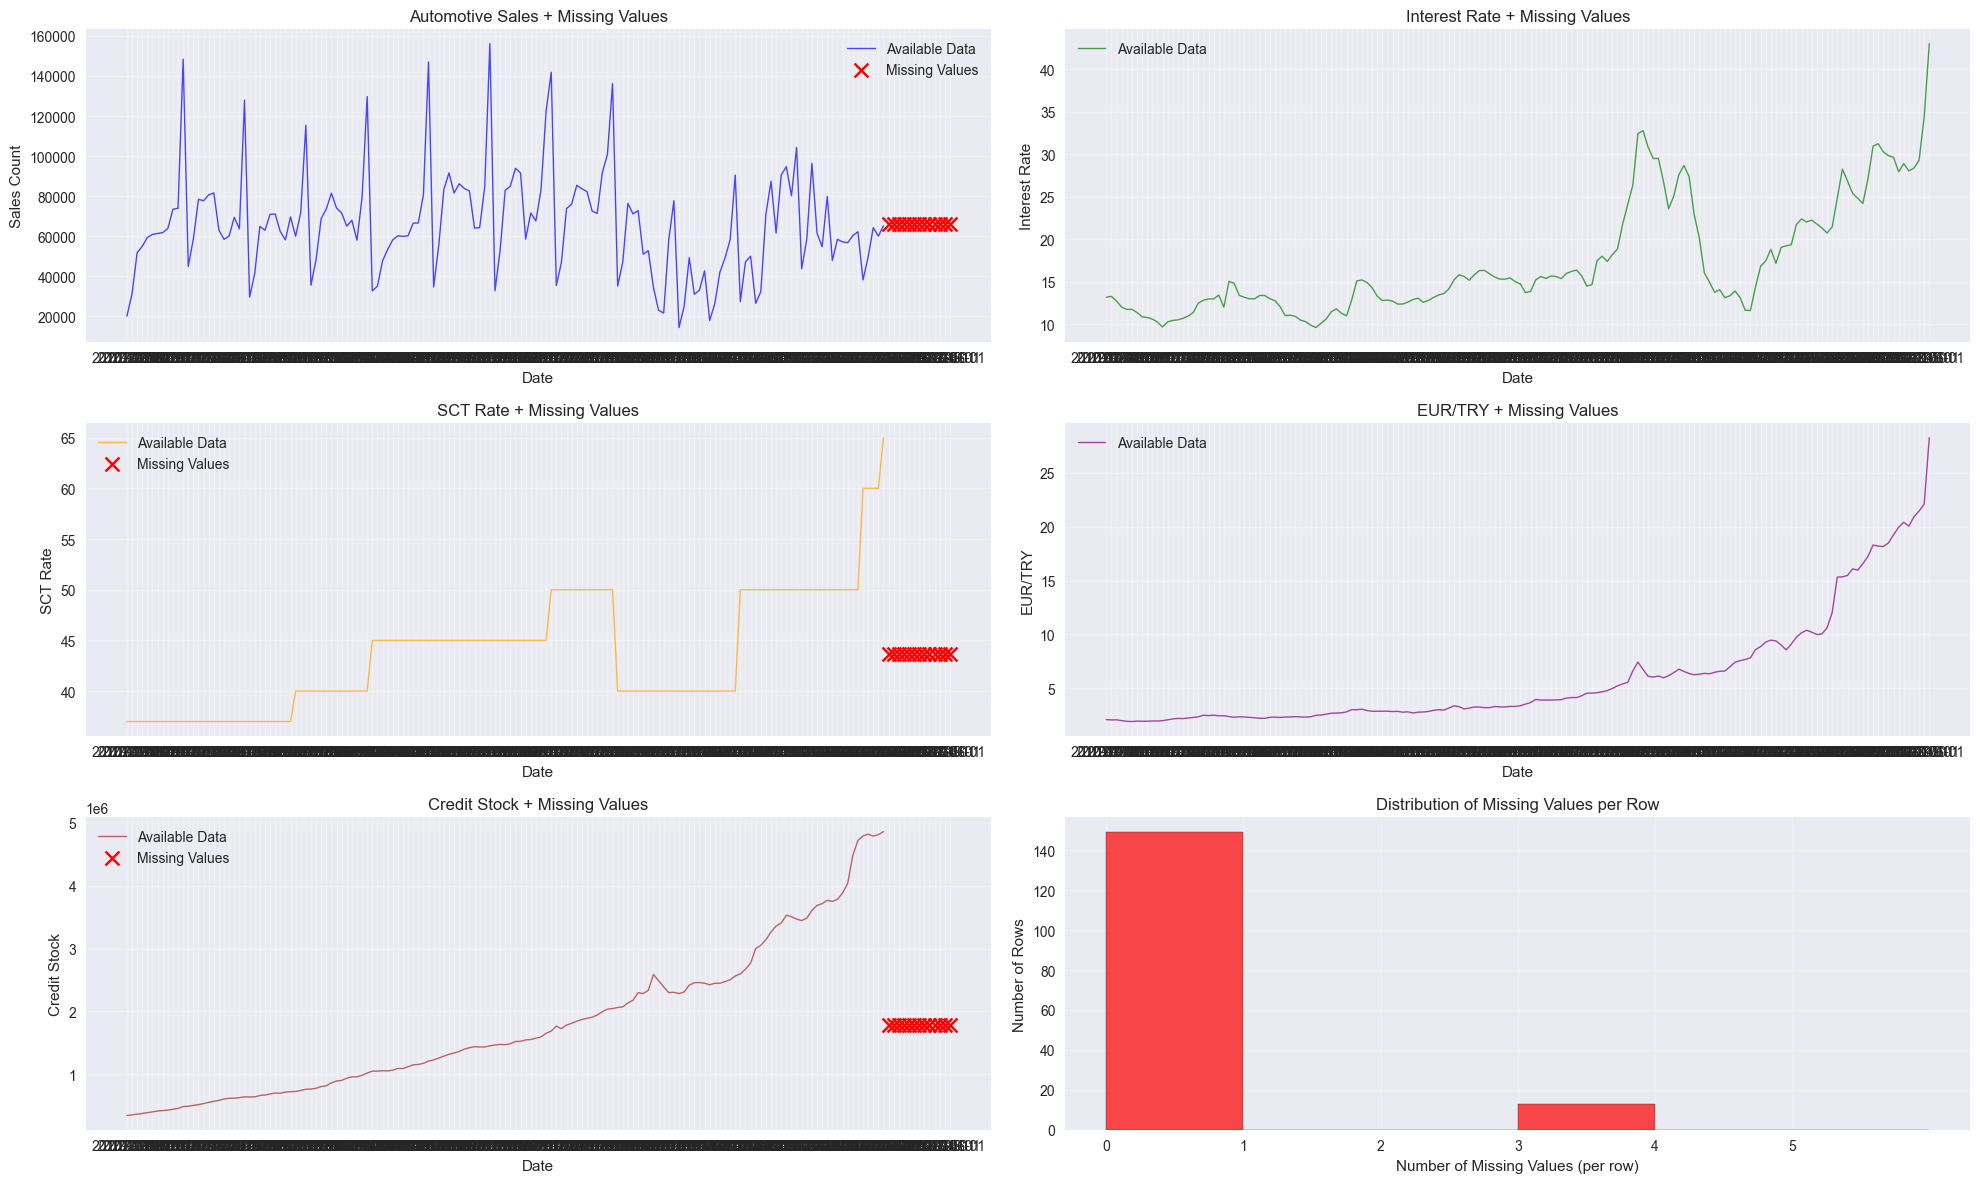

In [37]:

plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
plt.plot(df['Date'], df['Otomotiv Satis'], 'b-', linewidth=1, alpha=0.7, label='Available Data')
missing_sales = df[df['Otomotiv Satis'].isnull()]
if not missing_sales.empty:
    plt.scatter(missing_sales['Date'], [df['Otomotiv Satis'].mean()]*len(missing_sales), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('Automotive Sales + Missing Values')
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 2)
plt.plot(df['Date'], df['Faiz'], 'g-', linewidth=1, alpha=0.7, label='Available Data')
missing_faiz = df[df['Faiz'].isnull()]
if not missing_faiz.empty:
    plt.scatter(missing_faiz['Date'], [df['Faiz'].mean()]*len(missing_faiz), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('Interest Rate + Missing Values')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 3)
plt.plot(df['Date'], df['OTV Orani'], 'orange', linewidth=1, alpha=0.7, label='Available Data')
missing_otv = df[df['OTV Orani'].isnull()]
if not missing_otv.empty:
    plt.scatter(missing_otv['Date'], [df['OTV Orani'].mean()]*len(missing_otv), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('SCT Rate + Missing Values')
plt.xlabel('Date')
plt.ylabel('SCT Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 4)
plt.plot(df['Date'], df['EUR/TL'], 'purple', linewidth=1, alpha=0.7, label='Available Data')
missing_eur = df[df['EUR/TL'].isnull()]
if not missing_eur.empty:
    plt.scatter(missing_eur['Date'], [df['EUR/TL'].mean()]*len(missing_eur), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('EUR/TRY + Missing Values')
plt.xlabel('Date')
plt.ylabel('EUR/TRY')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 5)
plt.plot(df['Date'], df['Kredi Stok'], 'brown', linewidth=1, alpha=0.7, label='Available Data')
missing_kredi = df[df['Kredi Stok'].isnull()]
if not missing_kredi.empty:
    plt.scatter(missing_kredi['Date'], [df['Kredi Stok'].mean()]*len(missing_kredi), 
                color='red', s=100, marker='x', label='Missing Values')
plt.title('Credit Stock + Missing Values')
plt.xlabel('Date')
plt.ylabel('Credit Stock')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 6)
missing_by_row = df.isnull().sum(axis=1)
plt.hist(missing_by_row, bins=range(0, 7), alpha=0.7, color='red', edgecolor='black')
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of Missing Values (per row)')
plt.ylabel('Number of Rows')
plt.xticks(range(0, 6))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




### ÖTV Missing Value Analysis (EVDS)

Here, we use the forward fill (`ffill`) method to handle missing values in the "OTV Orani" (SCT Rate) column. 
This approach is appropriate because the SCT rate typically remains constant for a period after it is set, 
so any missing values can be reasonably filled with the most recent available value. 
By applying forward fill, we ensure that each missing entry is replaced with the last known SCT rate, 
preserving the temporal consistency of the data.

In [38]:

df["OTV Orani"] = df["OTV Orani"].ffill()

print("Remaining missing OTV rate:", df["OTV Orani"].isnull().sum())

df.to_csv("data\\filled_data\\eur_faiz_otv_filled.csv", index=False, encoding="utf-8-sig")

Remaining missing OTV rate: 0


### Kredi Stok Missing Value Analysis

Since we are not exactly sure which category this corresponds to, I am manually searching from the main category to the subcategory using the evds API.

In [39]:
print(evds.main_categories)

    CATEGORY_ID                                     TOPIC_TITLE_TR
0             1                             PİYASA VERİLERİ (TCMB)
1             2                                      KURLAR (TCMB)
2             3             FAİZ VE KÂR PAYI İSTATİSTİKLERİ (TCMB)
3             4          AYLIK PARA VE BANKA İSTATİSTİKLERİ (TCMB)
4             5                MENKUL KIYMET İSTATİSTİKLERİ (TCMB)
5            12                   FİNANSAL HİZMETLER ANKETİ (TCMB)
6            13             MERKEZ BANKASI BİLANÇO VERİLERİ (TCMB)
7            14                                   FİYAT ENDEKSLERİ
8            15                     İKTİSADİ YÖNELİM ANKETİ (TCMB)
9            18              ULUSLARARASI YATIRIM POZİSYONU (TCMB)
10           19                  DIŞ TİCARET İSTATİSTİKLERİ (TÜİK)
11           20                     KAMU MALİ İSTATİSTİKLERİ (HMB)
12           21                      ÜRETİME İLİŞKİN DİĞER VERİLER
13           22             ÖDEME SİSTEMLERİ İSTATİSTİKLERİ (T

In [40]:
series_list = evds.get_series("bie_kmmbkre")
print(series_list.head(20))

   SERIE_CODE                                    SERIE_NAME  START_DATE
0   TP.KM.B01                               1.GENEL YÖNETİM  01-12-2005
1   TP.KM.B02                           1.1 Merkezi Yönetim  01-01-1986
2   TP.KM.B03                          1.2 Yerel Yönetimler  01-01-1986
3   TP.KM.B04                 1.3 Sosyal Güvenlik Kurumları  01-01-2007
4   TP.KM.B05               2.MALİ OLMAYAN KAMU GİRİŞİMLERİ  01-01-1986
5   TP.KM.B06                                 3.ÖZEL SEKTÖR  01-01-1986
6   TP.KM.B07                    3.1 Mali Olmayan Şirketler  01-01-1986
7   TP.KM.B08           3.2 Bilgi için: Bireysel İşletmeler  01-12-2002
8   TP.KM.B09                                 3.3 Hanehalkı  01-01-1986
9   TP.KM.B10                       3.31 Tüketici Kredileri  01-01-1986
10  TP.KM.B11                         3.311 Konut Kredileri  01-12-2005
11  TP.KM.B12                         3.312 Taşıt Kredileri  01-12-2005
12  TP.KM.B13               3.313 İhtiyaç ve Diğer Krediler  01-

In [41]:
kredi_df = evds.get_data(
    ["TP.KM.B06", "TP.KM.B09", "TP.KM.B10", "TP.KM.B20"], 
    startdate="01-01-2010", 
    enddate="31-12-2023"
)

kredi_df["Tarih"] = pd.to_datetime(kredi_df["Tarih"], dayfirst=True)

print(kredi_df.head())

       Tarih        TP_KM_B06        TP_KM_B09        TP_KM_B10      TP_KM_B20
0 2010-01-01 288,757,995.0000 127,647,277.0000  91,448,126.0000 7,664,471.0000
1 2010-02-01 298,764,672.0000 129,543,350.0000  93,359,710.0000 8,138,634.0000
2 2010-03-01 310,086,529.0000 132,747,183.0000  96,407,621.0000 9,433,644.0000
3 2010-04-01 317,913,149.0000 136,313,404.0000  99,327,323.0000 9,233,472.0000
4 2010-05-01 331,930,770.0000 140,004,318.0000 102,011,464.0000 9,706,836.0000


In [42]:
kredi_df = evds.get_data(
    ["TP.KM.B06", "TP.KM.B09", "TP.KM.B10", "TP.KM.B20"], 
    startdate="01-01-2010", 
    enddate="31-12-2023"
)

kredi_df["Tarih"] = pd.to_datetime(kredi_df["Tarih"], dayfirst=True)

print(kredi_df.head())


df["Date"] = pd.to_datetime(df["Date"])


faizler = pd.DataFrame({
    "Date": kredi_df["Tarih"],
    "TP_KM_B06": pd.to_numeric(kredi_df["TP_KM_B06"], errors="coerce"),
    "TP_KM_B09": pd.to_numeric(kredi_df["TP_KM_B09"], errors="coerce"),
    "TP_KM_B10": pd.to_numeric(kredi_df["TP_KM_B10"], errors="coerce"),
    "TP_KM_B20": pd.to_numeric(kredi_df["TP_KM_B20"], errors="coerce"),
})


compare = df[["Date", "Kredi Stok"]].merge(faizler, on="Date", how="left")


results = {}
for col in ["TP_KM_B06", "TP_KM_B09", "TP_KM_B10", "TP_KM_B20"]:
    corr = compare[["Kredi Stok", col]].corr().iloc[0, 1]
    results[col] = corr

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["corr"]).sort_values("corr", ascending=False)
print(results_df)


       Tarih        TP_KM_B06        TP_KM_B09        TP_KM_B10      TP_KM_B20
0 2010-01-01 288,757,995.0000 127,647,277.0000  91,448,126.0000 7,664,471.0000
1 2010-02-01 298,764,672.0000 129,543,350.0000  93,359,710.0000 8,138,634.0000
2 2010-03-01 310,086,529.0000 132,747,183.0000  96,407,621.0000 9,433,644.0000
3 2010-04-01 317,913,149.0000 136,313,404.0000  99,327,323.0000 9,233,472.0000
4 2010-05-01 331,930,770.0000 140,004,318.0000 102,011,464.0000 9,706,836.0000
            corr
TP_KM_B06 0.9973
TP_KM_B09 0.9921
TP_KM_B10 0.9917
TP_KM_B20 0.9674


The scale of the data obtained from EVDS is different compared to our dataset. Specifically, the EVDS credit stock values are reported in thousands, whereas our dataset uses unit values. Therefore, to ensure both datasets are on the same scale and can be accurately compared or merged, we need to divide the EVDS credit stock values by 1,000. This adjustment brings the EVDS data down to the same unit level as our own data.

In [43]:
df['Kredi Stok'].min()

341244.126

In [44]:
df["Date"] = pd.to_datetime(df["Date"])


evds_kredi = pd.DataFrame({
    "Date": pd.to_datetime(kredi_df["Tarih"]),
    "TP_KM_B06": pd.to_numeric(kredi_df["TP_KM_B06"], errors="coerce") / 1_000,
    "TP_KM_B09": pd.to_numeric(kredi_df["TP_KM_B09"], errors="coerce") / 1_000,
    "TP_KM_B10": pd.to_numeric(kredi_df["TP_KM_B10"], errors="coerce") / 1_000,
    "TP_KM_B20": pd.to_numeric(kredi_df["TP_KM_B20"], errors="coerce") / 1_000,
})


compare = df[["Date", "Kredi Stok"]].merge(evds_kredi, on="Date", how="left")


results = {}
for col in ["TP_KM_B06", "TP_KM_B09", "TP_KM_B10", "TP_KM_B20"]:
    corr = compare[["Kredi Stok", col]].corr().iloc[0, 1]
    results[col] = corr

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["corr"]).sort_values("corr", ascending=False)
print(results_df)


            corr
TP_KM_B06 0.9973
TP_KM_B09 0.9921
TP_KM_B10 0.9917
TP_KM_B20 0.9674


In [45]:
evds_kredi = pd.DataFrame({
    "Date": pd.to_datetime(kredi_df["Tarih"]),
    "TP_KM_B06": pd.to_numeric(kredi_df["TP_KM_B06"], errors="coerce") / 1_000,
})


df_filled = df.merge(evds_kredi, on="Date", how="left")


df_filled["Kredi Stok"] = df_filled["Kredi Stok"].fillna(df_filled["TP_KM_B06"])


df_filled = df_filled.drop(columns=["TP_KM_B06"])

print("Missing Rows After The Process:", df_filled["Kredi Stok"].isnull().sum())


Missing Rows After The Process: 0


In [46]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["Date"], 
    y=df["Kredi Stok"], 
    mode="lines+markers",
    name="Original Credit Stock (With Missing Values)",
    line=dict(color="red"),
    opacity=0.8,
    connectgaps=False
))

fig.add_trace(go.Scatter(
    x=df_filled["Date"], 
    y=df_filled["Kredi Stok"], 
    mode="lines+markers",
    name="Filled Credit Stock (With TP_KM_B06)",
    line=dict(color="green"),
    opacity=0.6
))

fig.update_layout(
    title="Original vs Filled Credit Stock",
    xaxis_title="Date",
    yaxis_title="Million TL",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()


In [47]:

kredi_df_scaled = kredi_df.copy()
kredi_df_scaled["TP_KM_B06"] = pd.to_numeric(kredi_df_scaled["TP_KM_B06"], errors="coerce") / 1_000
kredi_df_scaled["Tarih"] = pd.to_datetime(kredi_df_scaled["Tarih"])

kredi_evds = kredi_df_scaled[["Tarih", "TP_KM_B06"]].rename(columns={"Tarih": "Date"})

df = df.merge(kredi_evds, on="Date", how="left")

df["Kredi Stok"] = df["Kredi Stok"].fillna(df["TP_KM_B06"])

df = df.drop(columns=["TP_KM_B06"])

print("Any missing Credit Stock left:", df["Kredi Stok"].isnull().sum())


Any missing Credit Stock left: 0


In [48]:
output_path = "data\\filled_data\\eur_faiz_otv_kredi_filled.csv"
df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"Filled dataset has been saved: {output_path}")


Filled dataset has been saved: data\filled_data\eur_faiz_otv_kredi_filled.csv


In [49]:
filled_df = pd.read_csv("data\\filled_data\\eur_faiz_otv_kredi_filled.csv")

first_null_idx = filled_df["Otomotiv Satis"].isnull().idxmax() if filled_df["Otomotiv Satis"].isnull().any() else len(filled_df)

train_df = filled_df.iloc[:first_null_idx].copy()
test_df = filled_df.iloc[first_null_idx:].copy()

train_df.to_csv("data/final_data/train.csv", index=False, encoding="utf-8-sig")
test_df.to_csv("data/final_data/test.csv", index=False, encoding="utf-8-sig")

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")


Train shape: (149, 6), Test shape: (13, 6)


### Final Plot After Fill (EVDS)

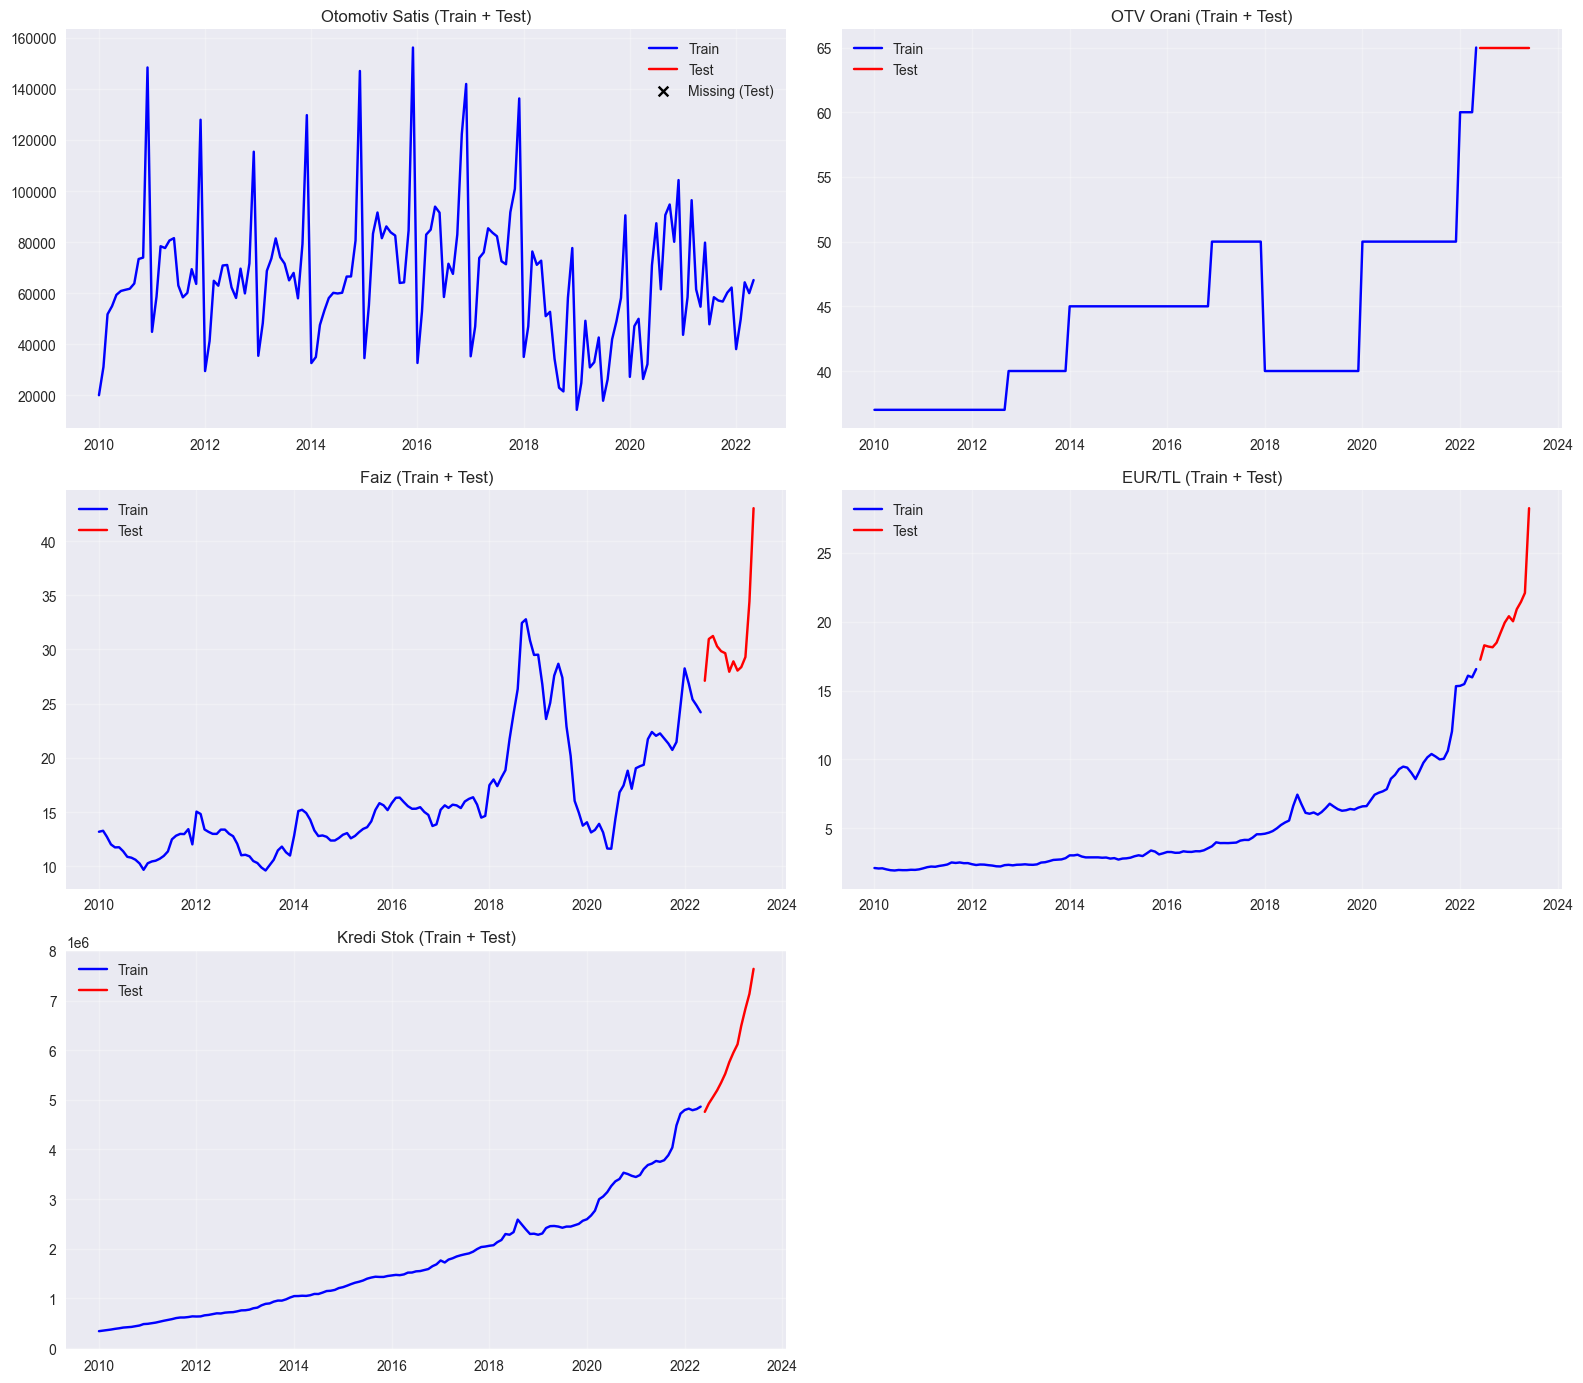

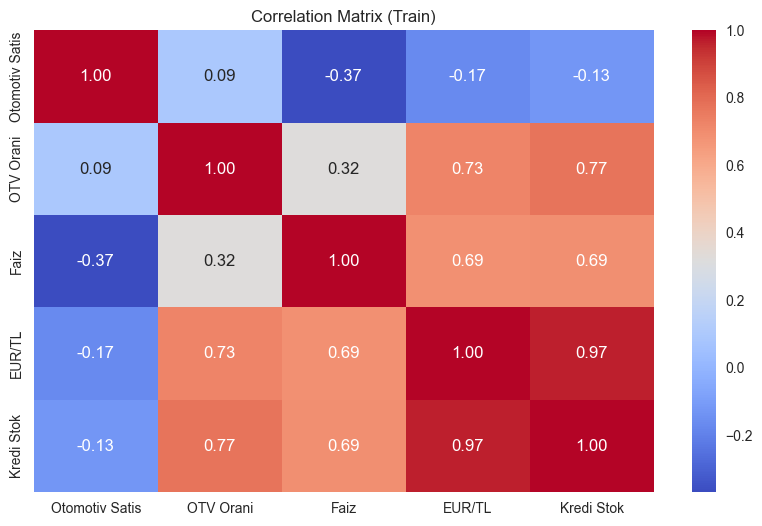

Correlation Table:
                 Otomotiv Satis  OTV Orani    Faiz  EUR/TL  Kredi Stok
Otomotiv Satis          1.0000     0.0910 -0.3693 -0.1679     -0.1256
OTV Orani               0.0910     1.0000  0.3216  0.7265      0.7705
Faiz                   -0.3693     0.3216  1.0000  0.6889      0.6919
EUR/TL                 -0.1679     0.7265  0.6889  1.0000      0.9667
Kredi Stok             -0.1256     0.7705  0.6919  0.9667      1.0000


In [50]:
train = pd.read_csv("data/final_data/train.csv")
test = pd.read_csv("data/final_data/test.csv")

train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])
train = train.set_index("Date")
test = test.set_index("Date")

nan_mask_train = train.isna()
nan_mask_test = test.isna()

all_data = pd.concat([train, test], axis=0)

fig, axes = plt.subplots(nrows=(len(all_data.columns) + 1)//2, ncols=2, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(all_data.columns):
    ax = axes[i]
    ax.plot(train.index, train[col], label="Train", color="blue")
    if nan_mask_train[col].any():
        ax.scatter(train.index[nan_mask_train[col]], [train[col].mean()]*nan_mask_train[col].sum(), 
                   color="red", marker="x", label="Missing (Train)")
    ax.plot(test.index, test[col], label="Test", color="red")
    if nan_mask_test[col].any():
        ax.scatter(test.index[nan_mask_test[col]], [test[col].mean()]*nan_mask_test[col].sum(), 
                   color="black", marker="x", label="Missing (Test)")
    ax.set_title(f"{col} (Train + Test)")
    ax.grid(True, alpha=0.3)
    ax.legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

corr = train.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (Train)")
plt.show()

print("Correlation Table:\n", corr)


# Part 2 Filling Missing Values With Prophet Predictions


The Prophet models in this section were run and their parameters were tuned outside of this notebook. I transferred the code for the final model into the notebook.

In [51]:
def save_model_and_forecast(model, forecast, model_name):
    model_dir = os.path.join("models", model_name)
    os.makedirs(model_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(model_dir, "prophet_model.pkl")
    joblib.dump(model, model_path)

    # Save forecast
    forecast_out = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]
    forecast_path = os.path.join(model_dir, f"{model_name}_forecast.csv")
    forecast_out.to_csv(forecast_path)

    print(f"Model saved to {model_path}")
    print(f"Forecast saved to {forecast_path}")

### Predicting EUR/TL feature.

15:50:24 - cmdstanpy - INFO - Chain [1] start processing
15:50:26 - cmdstanpy - INFO - Chain [1] done processing


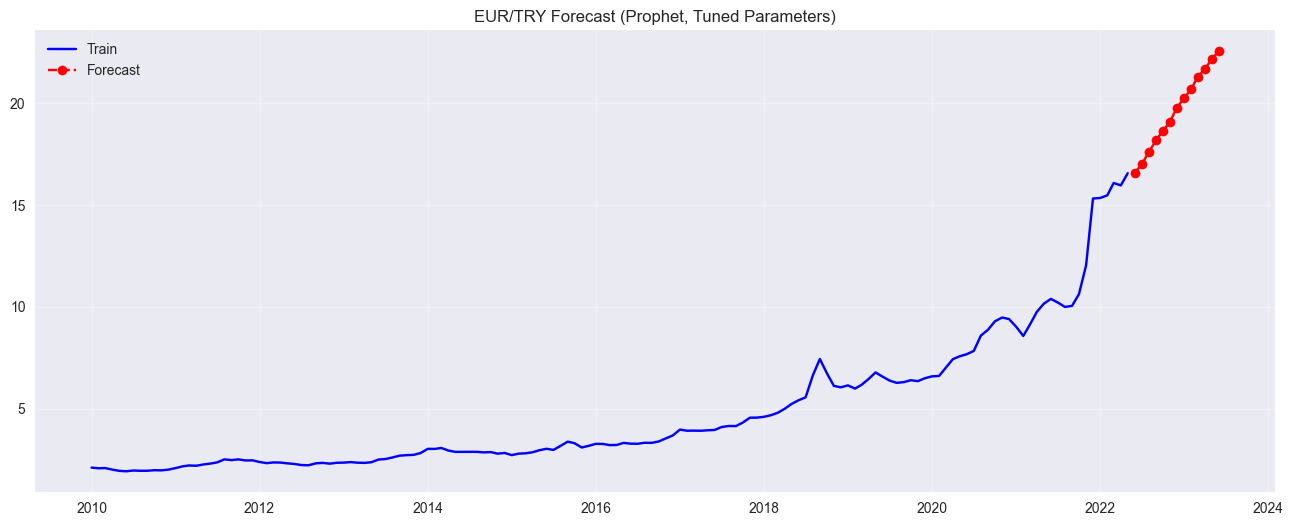

              yhat  yhat_lower  yhat_upper
ds                                        
2022-06-01 16.5811     16.0151     17.0885
2022-07-01 16.9958     16.4225     17.5594
2022-08-01 17.5974     17.0652     18.1477
2022-09-01 18.1795     17.6298     18.7521
2022-10-01 18.6388     18.0638     19.1860
2022-11-01 19.0908     18.4889     19.6943
2022-12-01 19.7832     19.1250     20.4109
2023-01-01 20.2548     19.5880     20.9041
2023-02-01 20.6760     20.0163     21.3342
2023-03-01 21.3005     20.5347     22.0418
2023-04-01 21.6553     20.8288     22.3933
2023-05-01 22.1691     21.3465     22.9243
2023-06-01 22.5446     21.6362     23.4308


In [52]:
train = pd.read_csv(r"data\final_data\train.csv")
test = pd.read_csv(r"data\final_data\test.csv")

train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

df_prophet = train.rename(columns={"Date": "ds", "EUR/TL": "y"}).dropna()

best_params = {
    "changepoint_prior_scale": 0.5,
    "seasonality_prior_scale": 5.0,
    "changepoint_range": 0.9,
    "seasonality_mode": "additive"
}

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    **best_params
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=13, freq="MS")
forecast = model.predict(future)

plt.figure(figsize=(16,6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Train", color="blue")
plt.plot(forecast["ds"].iloc[-13:], forecast["yhat"].iloc[-13:], 
         "r--o", label="Forecast")
plt.title("EUR/TRY Forecast (Prophet, Tuned Parameters)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

forecast_out = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].iloc[-13:]
print(forecast_out)


In [53]:
test_start = test["Date"].min()

eur_forecast = (
    forecast.set_index("ds")
    .loc[test_start:, ["yhat", "yhat_lower", "yhat_upper"]]
)

output_path = r"data\filled_data_prediction\eur_forecast.csv"
eur_forecast.to_csv(output_path, index=True)

print(f"EUR/TRY forecast saved to '{output_path}'")
print(eur_forecast.head())


EUR/TRY forecast saved to 'data\filled_data_prediction\eur_forecast.csv'
              yhat  yhat_lower  yhat_upper
ds                                        
2022-06-01 16.5811     16.0151     17.0885
2022-07-01 16.9958     16.4225     17.5594
2022-08-01 17.5974     17.0652     18.1477
2022-09-01 18.1795     17.6298     18.7521
2022-10-01 18.6388     18.0638     19.1860


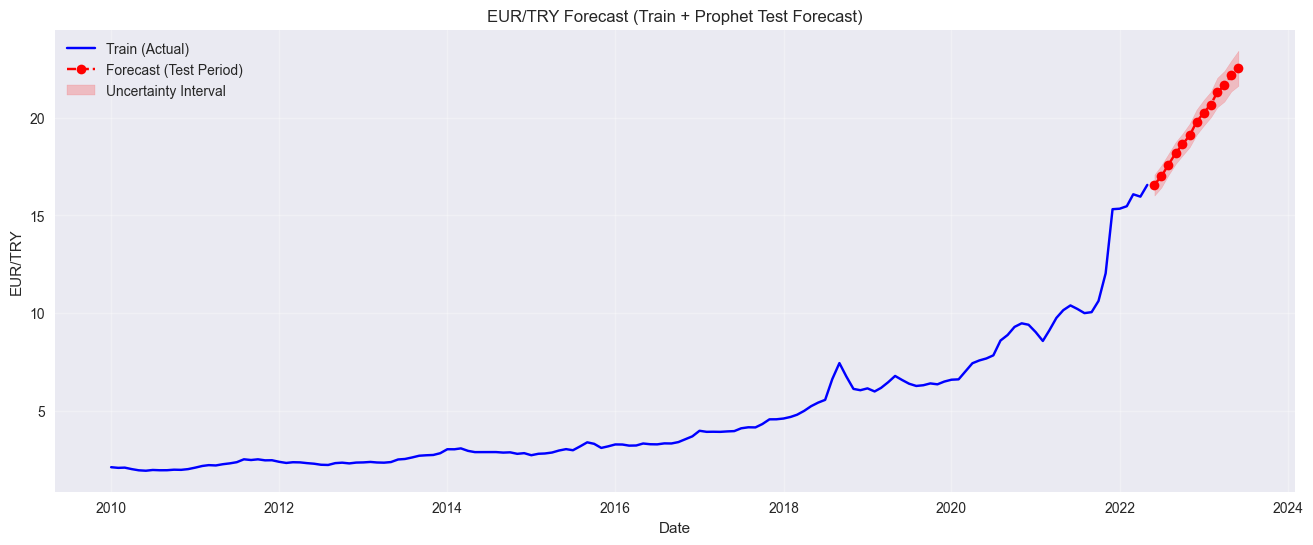

In [54]:
plt.figure(figsize=(16, 6))

plt.plot(train["Date"], train["EUR/TL"], label="Train (Actual)", color="blue")
plt.plot(eur_forecast.index, eur_forecast["yhat"], "r--o", label="Forecast (Test Period)")

plt.fill_between(
    eur_forecast.index,
    eur_forecast["yhat_lower"],
    eur_forecast["yhat_upper"],
    color="red",
    alpha=0.2,
    label="Uncertainty Interval"
)

plt.title("EUR/TRY Forecast (Train + Prophet Test Forecast)")
plt.xlabel("Date")
plt.ylabel("EUR/TRY")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [55]:
save_model_and_forecast(model, forecast, "eur_try")

Model saved to models\eur_try\prophet_model.pkl
Forecast saved to models\eur_try\eur_try_forecast.csv


### Predicting Faiz feature.

In [56]:

train = pd.read_csv(r"data\final_data\train.csv")
train["Date"] = pd.to_datetime(train["Date"])


df_faiz = train.reset_index()[["Date", "Faiz"]].rename(columns={"Date": "ds", "Faiz": "y"})


In [57]:
best_params = {
    "changepoint_prior_scale": 0.34,
    "seasonality_prior_scale": 6.93,
    "changepoint_range": 0.87,
    "seasonality_mode": "multiplicative"
}

m = Prophet(
    **best_params,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
m.fit(df_faiz)


15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:27 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
future = m.make_future_dataframe(periods=13, freq="MS")  # 13 ay ileri
forecast = m.predict(future)

faiz_forecast = forecast[forecast["ds"] >= "2022-06-01"][["ds", "yhat", "yhat_lower", "yhat_upper"]]
print(faiz_forecast)


            ds    yhat  yhat_lower  yhat_upper
149 2022-06-01 28.0729     25.7845     30.1660
150 2022-07-01 28.9606     26.7381     31.1685
151 2022-08-01 28.8760     26.8227     31.0201
152 2022-09-01 30.4688     28.1922     32.7153
153 2022-10-01 30.0340     27.6365     32.2676
154 2022-11-01 29.6445     27.2066     32.0129
155 2022-12-01 29.6658     27.2208     32.1561
156 2023-01-01 32.2098     29.7199     34.9157
157 2023-02-01 32.1602     29.3043     34.9859
158 2023-03-01 30.8492     28.0442     33.8276
159 2023-04-01 31.2011     27.9847     34.4225
160 2023-05-01 33.1174     29.4408     36.5751
161 2023-06-01 35.6969     31.6392     39.9006


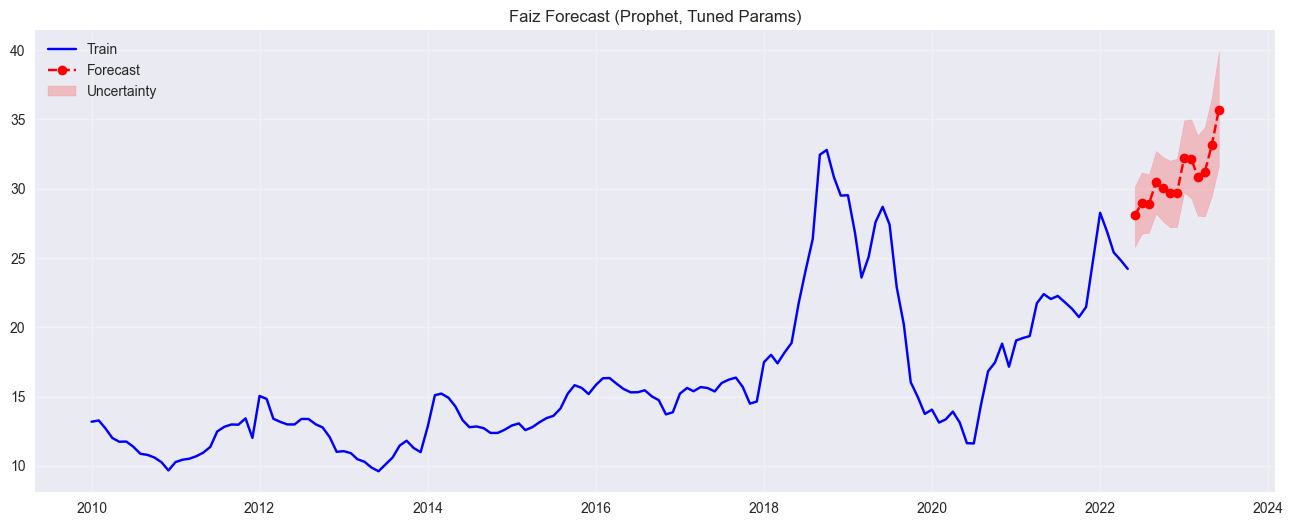

In [59]:
plt.figure(figsize=(16,6))
plt.plot(df_faiz["ds"], df_faiz["y"], label="Train", color="blue")
plt.plot(faiz_forecast["ds"], faiz_forecast["yhat"], "r--o", label="Forecast")
plt.fill_between(
    faiz_forecast["ds"],
    faiz_forecast["yhat_lower"],
    faiz_forecast["yhat_upper"],
    color="red", alpha=0.2, label="Uncertainty"
)
plt.title("Faiz Forecast (Prophet, Tuned Params)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [60]:
output_path = r"data\filled_data_prediction\faiz_forecast.csv"
faiz_forecast.to_csv(output_path, index=False)

print(f"Faiz forecast saved to '{output_path}'")
print(faiz_forecast.head())


Faiz forecast saved to 'data\filled_data_prediction\faiz_forecast.csv'
            ds    yhat  yhat_lower  yhat_upper
149 2022-06-01 28.0729     25.7845     30.1660
150 2022-07-01 28.9606     26.7381     31.1685
151 2022-08-01 28.8760     26.8227     31.0201
152 2022-09-01 30.4688     28.1922     32.7153
153 2022-10-01 30.0340     27.6365     32.2676


In [61]:
save_model_and_forecast(m, faiz_forecast, "faiz_prophet")

Model saved to models\faiz_prophet\prophet_model.pkl
Forecast saved to models\faiz_prophet\faiz_prophet_forecast.csv


## Predicting Kredi Stock Feature

In [62]:
train = pd.read_csv(r"data\final_data\train.csv")
test = pd.read_csv(r"data\final_data\test.csv")

train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])


df_kredi = train[["Date", "Kredi Stok"]].rename(columns={"Date": "ds", "Kredi Stok": "y"})

In [63]:

best_params = {
    "changepoint_prior_scale": 0.4182014382170599,
    "seasonality_prior_scale": 2.546809736136111,
    "changepoint_range": 0.9101478312322142,
    "seasonality_mode": "multiplicative"
}


final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    **best_params
)
final_model.fit(df_kredi)

15:50:27 - cmdstanpy - INFO - Chain [1] start processing
15:50:27 - cmdstanpy - INFO - Chain [1] done processing


In [64]:

future = test[["Date"]].rename(columns={"Date": "ds"})
forecast = final_model.predict(future)


kredi_forecast = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]]


output_path = r"data\filled_data_prediction\kredi_forecast.csv"
kredi_forecast.to_csv(output_path)
print(f"Kredi Stok forecast saved to '{output_path}'")


Kredi Stok forecast saved to 'data\filled_data_prediction\kredi_forecast.csv'


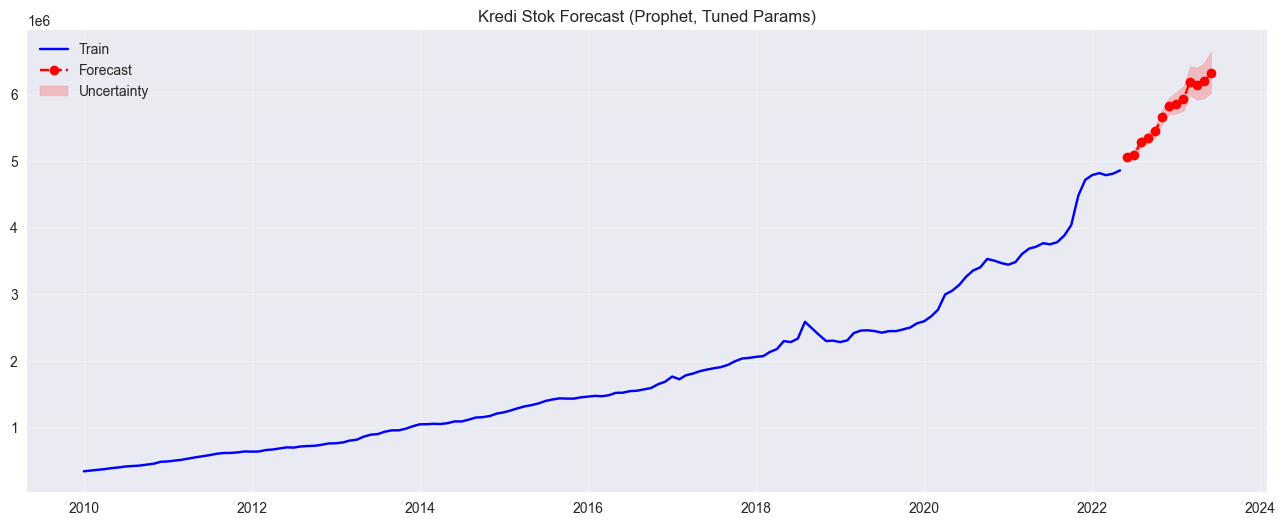

In [65]:
plt.figure(figsize=(16,6))
plt.plot(df_kredi["ds"], df_kredi["y"], label="Train", color="blue")
plt.plot(kredi_forecast.index, kredi_forecast["yhat"], "r--o", label="Forecast")
plt.fill_between(
    kredi_forecast.index,
    kredi_forecast["yhat_lower"],
    kredi_forecast["yhat_upper"],
    color="red", alpha=0.2, label="Uncertainty"
)
plt.title("Kredi Stok Forecast (Prophet, Tuned Params)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [66]:
save_model_and_forecast(final_model, forecast, "kredi_prophet")

Model saved to models\kredi_prophet\prophet_model.pkl
Forecast saved to models\kredi_prophet\kredi_prophet_forecast.csv


## Merge the fill data with Dummy ÖTV

In [67]:
otv_series = train["OTV Orani"]


last_otv = otv_series.iloc[-1]
print("Last OTV value:", last_otv)


otv_forecast_df = pd.DataFrame({
    "ds": test.index,
    "yhat": last_otv,
    "yhat_lower": last_otv,
    "yhat_upper": last_otv
}).set_index("ds")


otv_forecast_df.to_csv(r"data\filled_data_prediction\otv_forecast.csv")
print("otv_forecast.csv saved!")
print(otv_forecast_df.head())


Last OTV value: 65.0
otv_forecast.csv saved!
      yhat  yhat_lower  yhat_upper
ds                                
0  65.0000     65.0000     65.0000
1  65.0000     65.0000     65.0000
2  65.0000     65.0000     65.0000
3  65.0000     65.0000     65.0000
4  65.0000     65.0000     65.0000


In [68]:
base_path = r"data\filled_data_prediction"
eur_path   = os.path.join(base_path, "eur_forecast.csv")
faiz_path  = os.path.join(base_path, "faiz_forecast.csv")
kredi_path = os.path.join(base_path, "kredi_forecast.csv")
otv_path   = os.path.join(base_path, "otv_forecast.csv")
output_path = r"data\final_data\test_filled.csv"


eur_forecast   = pd.read_csv(eur_path, index_col="ds", parse_dates=True)
faiz_forecast  = pd.read_csv(faiz_path, index_col="ds", parse_dates=True)
kredi_forecast = pd.read_csv(kredi_path, index_col="ds", parse_dates=True)
otv_forecast   = pd.read_csv(otv_path, index_col="ds", parse_dates=True)


test = pd.read_csv(r"data\final_data\test.csv", parse_dates=["Date"])
test = test.set_index("Date")


test_filled = test.copy()
test_filled["EUR/TL"]     = eur_forecast["yhat"].reindex(test.index)
test_filled["Faiz"]       = faiz_forecast["yhat"].reindex(test.index)
test_filled["Kredi Stok"] = kredi_forecast["yhat"].reindex(test.index)
test_filled["OTV Orani"]  = 65   


test_filled.to_csv(output_path, index=True)
print(f"test_filled.csv saved to '{output_path}'")
print(test_filled.head())

test_filled.csv saved to 'data\final_data\test_filled.csv'
            Otomotiv Satis  OTV Orani    Faiz  EUR/TL     Kredi Stok
Date                                                                
2022-06-01             NaN         65 28.0729 16.5811 5,060,853.2344
2022-07-01             NaN         65 28.9606 16.9958 5,096,435.7054
2022-08-01             NaN         65 28.8760 17.5974 5,288,861.8947
2022-09-01             NaN         65 30.4688 18.1795 5,351,485.2312
2022-10-01             NaN         65 30.0340 18.6388 5,448,380.8638


C:\Users\gokal\AppData\Local\Temp\ipykernel_64124\3764096714.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



## Plot of the Final Data

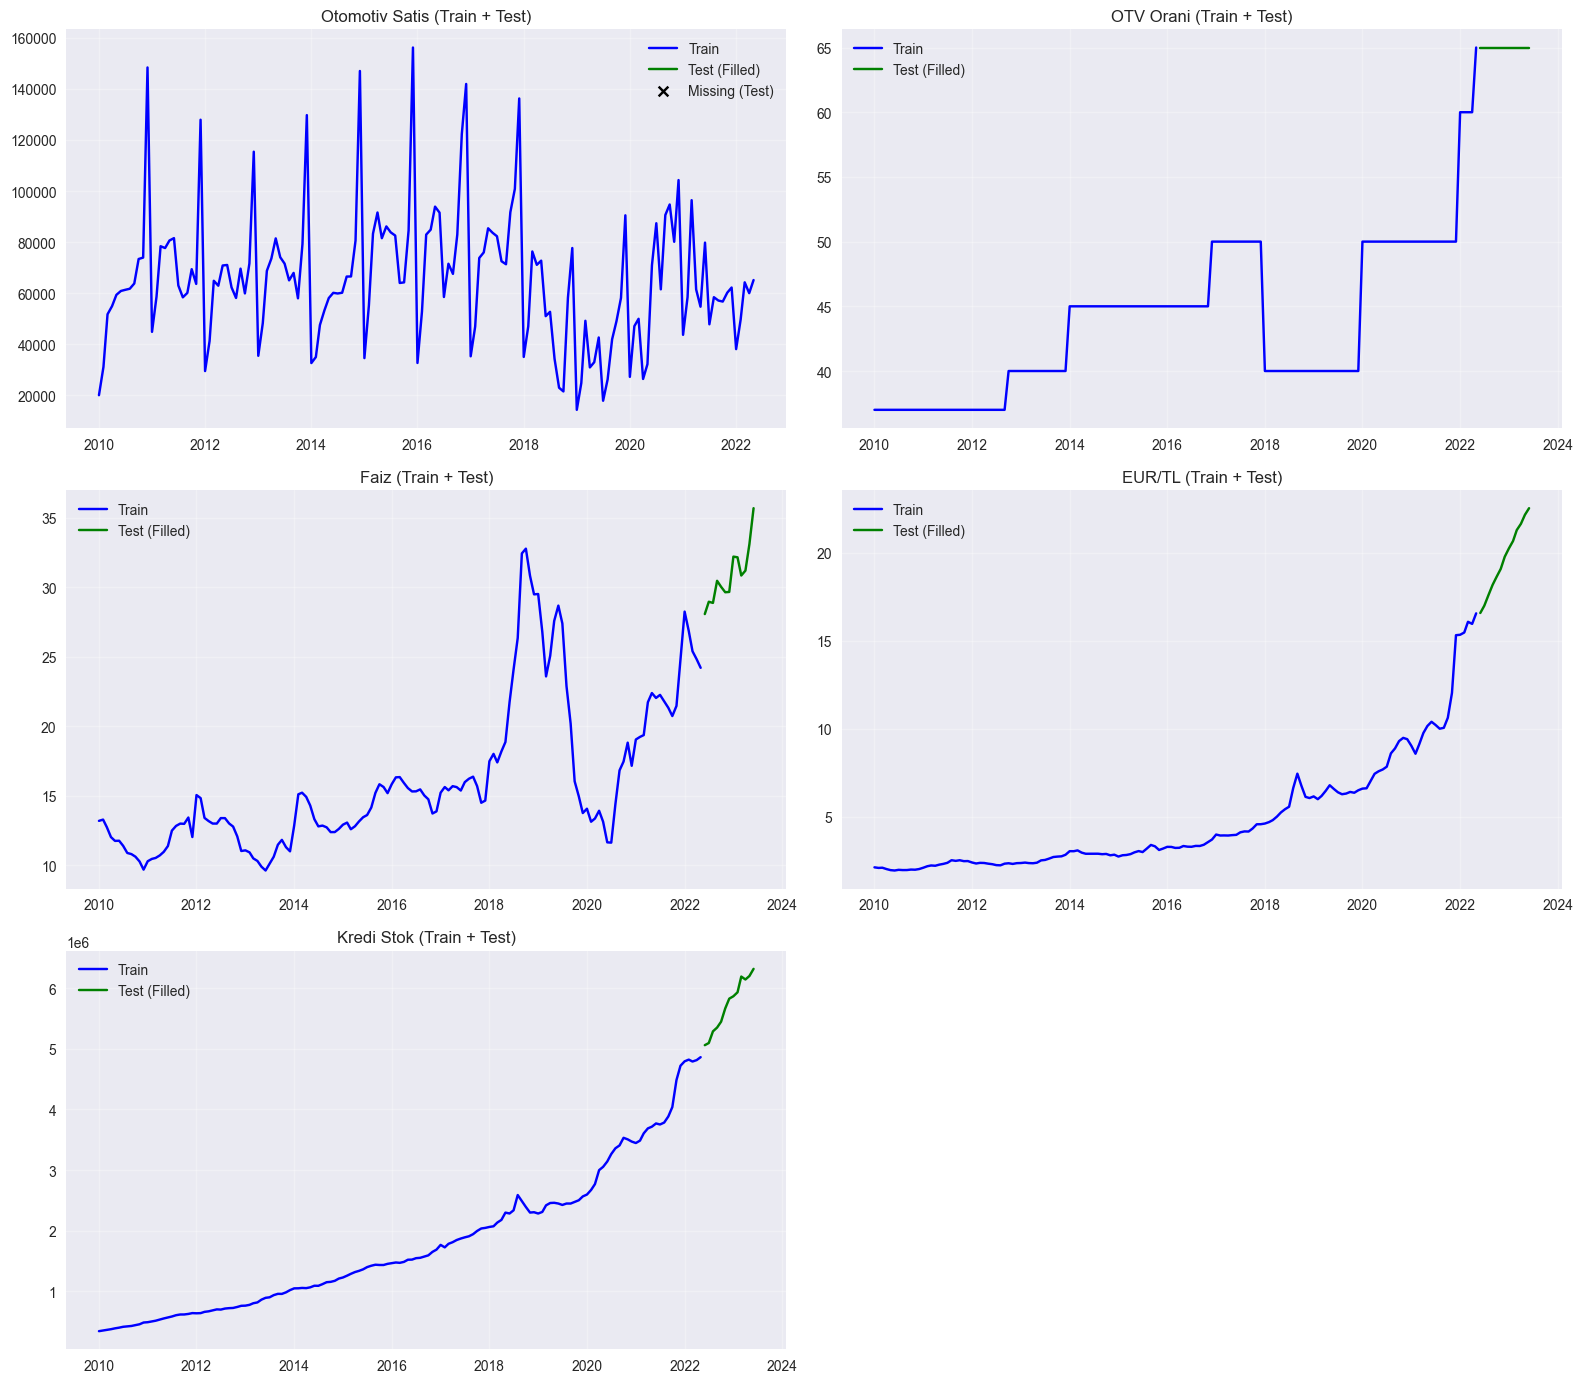

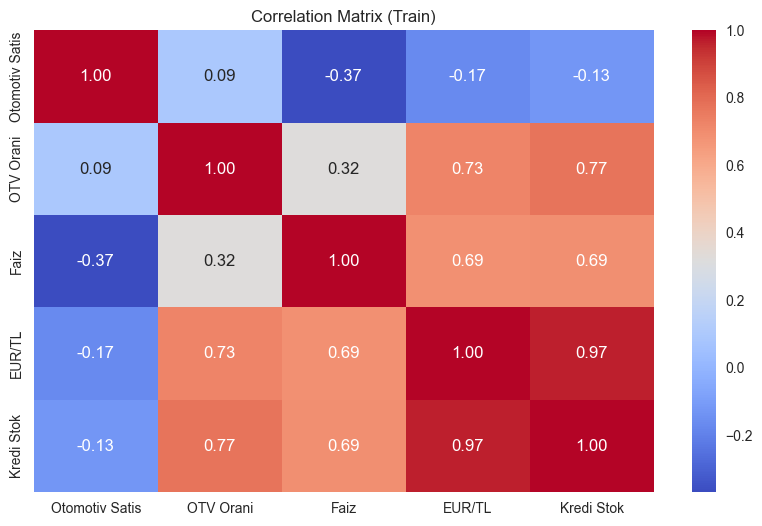

Correlation Table:
                 Otomotiv Satis  OTV Orani    Faiz  EUR/TL  Kredi Stok
Otomotiv Satis          1.0000     0.0910 -0.3693 -0.1679     -0.1256
OTV Orani               0.0910     1.0000  0.3216  0.7265      0.7705
Faiz                   -0.3693     0.3216  1.0000  0.6889      0.6919
EUR/TL                 -0.1679     0.7265  0.6889  1.0000      0.9667
Kredi Stok             -0.1256     0.7705  0.6919  0.9667      1.0000


In [69]:
train = pd.read_csv("data/final_data/train.csv")
test_filled = pd.read_csv("data/final_data/test_filled.csv")

train["Date"] = pd.to_datetime(train["Date"])
test_filled["Date"] = pd.to_datetime(test_filled["Date"])

train = train.set_index("Date")
test_filled = test_filled.set_index("Date")


nan_mask_train = train.isna()
nan_mask_test = test_filled.isna()

all_data = pd.concat([train, test_filled], axis=0)

fig, axes = plt.subplots(nrows=(len(all_data.columns) + 1)//2, ncols=2, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(all_data.columns):
    ax = axes[i]
    ax.plot(train.index, train[col], label="Train", color="blue")
    if nan_mask_train[col].any():
        ax.scatter(train.index[nan_mask_train[col]], [train[col].mean()]*nan_mask_train[col].sum(), 
                   color="red", marker="x", label="Missing (Train)")
    ax.plot(test_filled.index, test_filled[col], label="Test (Filled)", color="green")
    if nan_mask_test[col].any():
        ax.scatter(test_filled.index[nan_mask_test[col]], [test_filled[col].mean()]*nan_mask_test[col].sum(), 
                   color="black", marker="x", label="Missing (Test)")
    ax.set_title(f"{col} (Train + Test)")
    ax.grid(True, alpha=0.3)
    ax.legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


corr = train.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix (Train)")
plt.show()

print("Correlation Table:\n", corr)


# Part 4 Modelling

Part 4: Modeling Overview

1. Classical Statistical Models
   - ARIMA / SARIMA:
       * Basic ARIMA and SARIMA models with seasonality.
   - AutoARIMA + Exogenous Features (ARIMAX/SARIMAX):
       * Incorporated macroeconomic variables (OTV, Interest Rate, EUR/TRY, Credit Stock) as exogenous features.
       * Enhanced with feature engineering: lag, rolling mean/std, and percentage change.
   - AutoARIMA + PCA:
       * Applied PCA for dimensionality reduction on highly correlated exogenous variables.

2. Machine Learning Models
   - XGBoost:
       * Included lag, rolling, and time-based features.
       * Performed hyperparameter tuning with GridSearchCV.
       * Utilized Optuna for advanced parameter optimization.
       * Evaluated with various data splitting strategies:
           - Expanding Window CV
           - Rolling Window CV
           - Purged K-Fold CV (forward-chaining)
           - Blocked CV (scenario-based split)

3. Hybrid Models
   - ARIMA + XGBoost Residuals:
       * Modeled linear and seasonal patterns with ARIMA, then modeled residuals using XGBoost.

4. Prophet
   - Implemented Prophet model.
   - Tuned parameters (changepoint_prior_scale, seasonality_prior_scale, seasonality_mode).
   - Visualized results across validation folds.
   - Tested Prophet under different split scenarios.

5. Split / Validation Strategies
   - Expanding Window CV
   - Rolling Window CV
   - Purged K-Fold CV
   - Blocked CV (scenario-based split)


Due to space limitations, we will focus on presenting and discussing the following selected models in detail which is hybrid model that includes SARIMA and Prophet model

In [70]:
train = pd.read_csv("data\\final_data\\train.csv")
train["Date"] = pd.to_datetime(train["Date"])
train = train.set_index("Date")

test = pd.read_csv("data\\final_data\\test.csv")
test["Date"] = pd.to_datetime(test["Date"])
test = test.set_index("Date")

y = train["Otomotiv Satis"]

In [71]:
crisis_dummy = pd.Series(
    ((train.index >= "2018-01-01") & (train.index <= "2020-12-31")).astype(int),
    index=train.index
)

# Exog features
exog_vars = ["EUR/TL", "Faiz", "Kredi Stok", "OTV Orani"]
X = train[exog_vars]
X_test = test[exog_vars]

15:50:28 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing
d:\GIT\Linktera\linktera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

d:\GIT\Linktera\linktera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

d:\GIT\Linktera\linktera\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing
d:\GIT\Linktera\linktera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

d:\GIT\Linktera

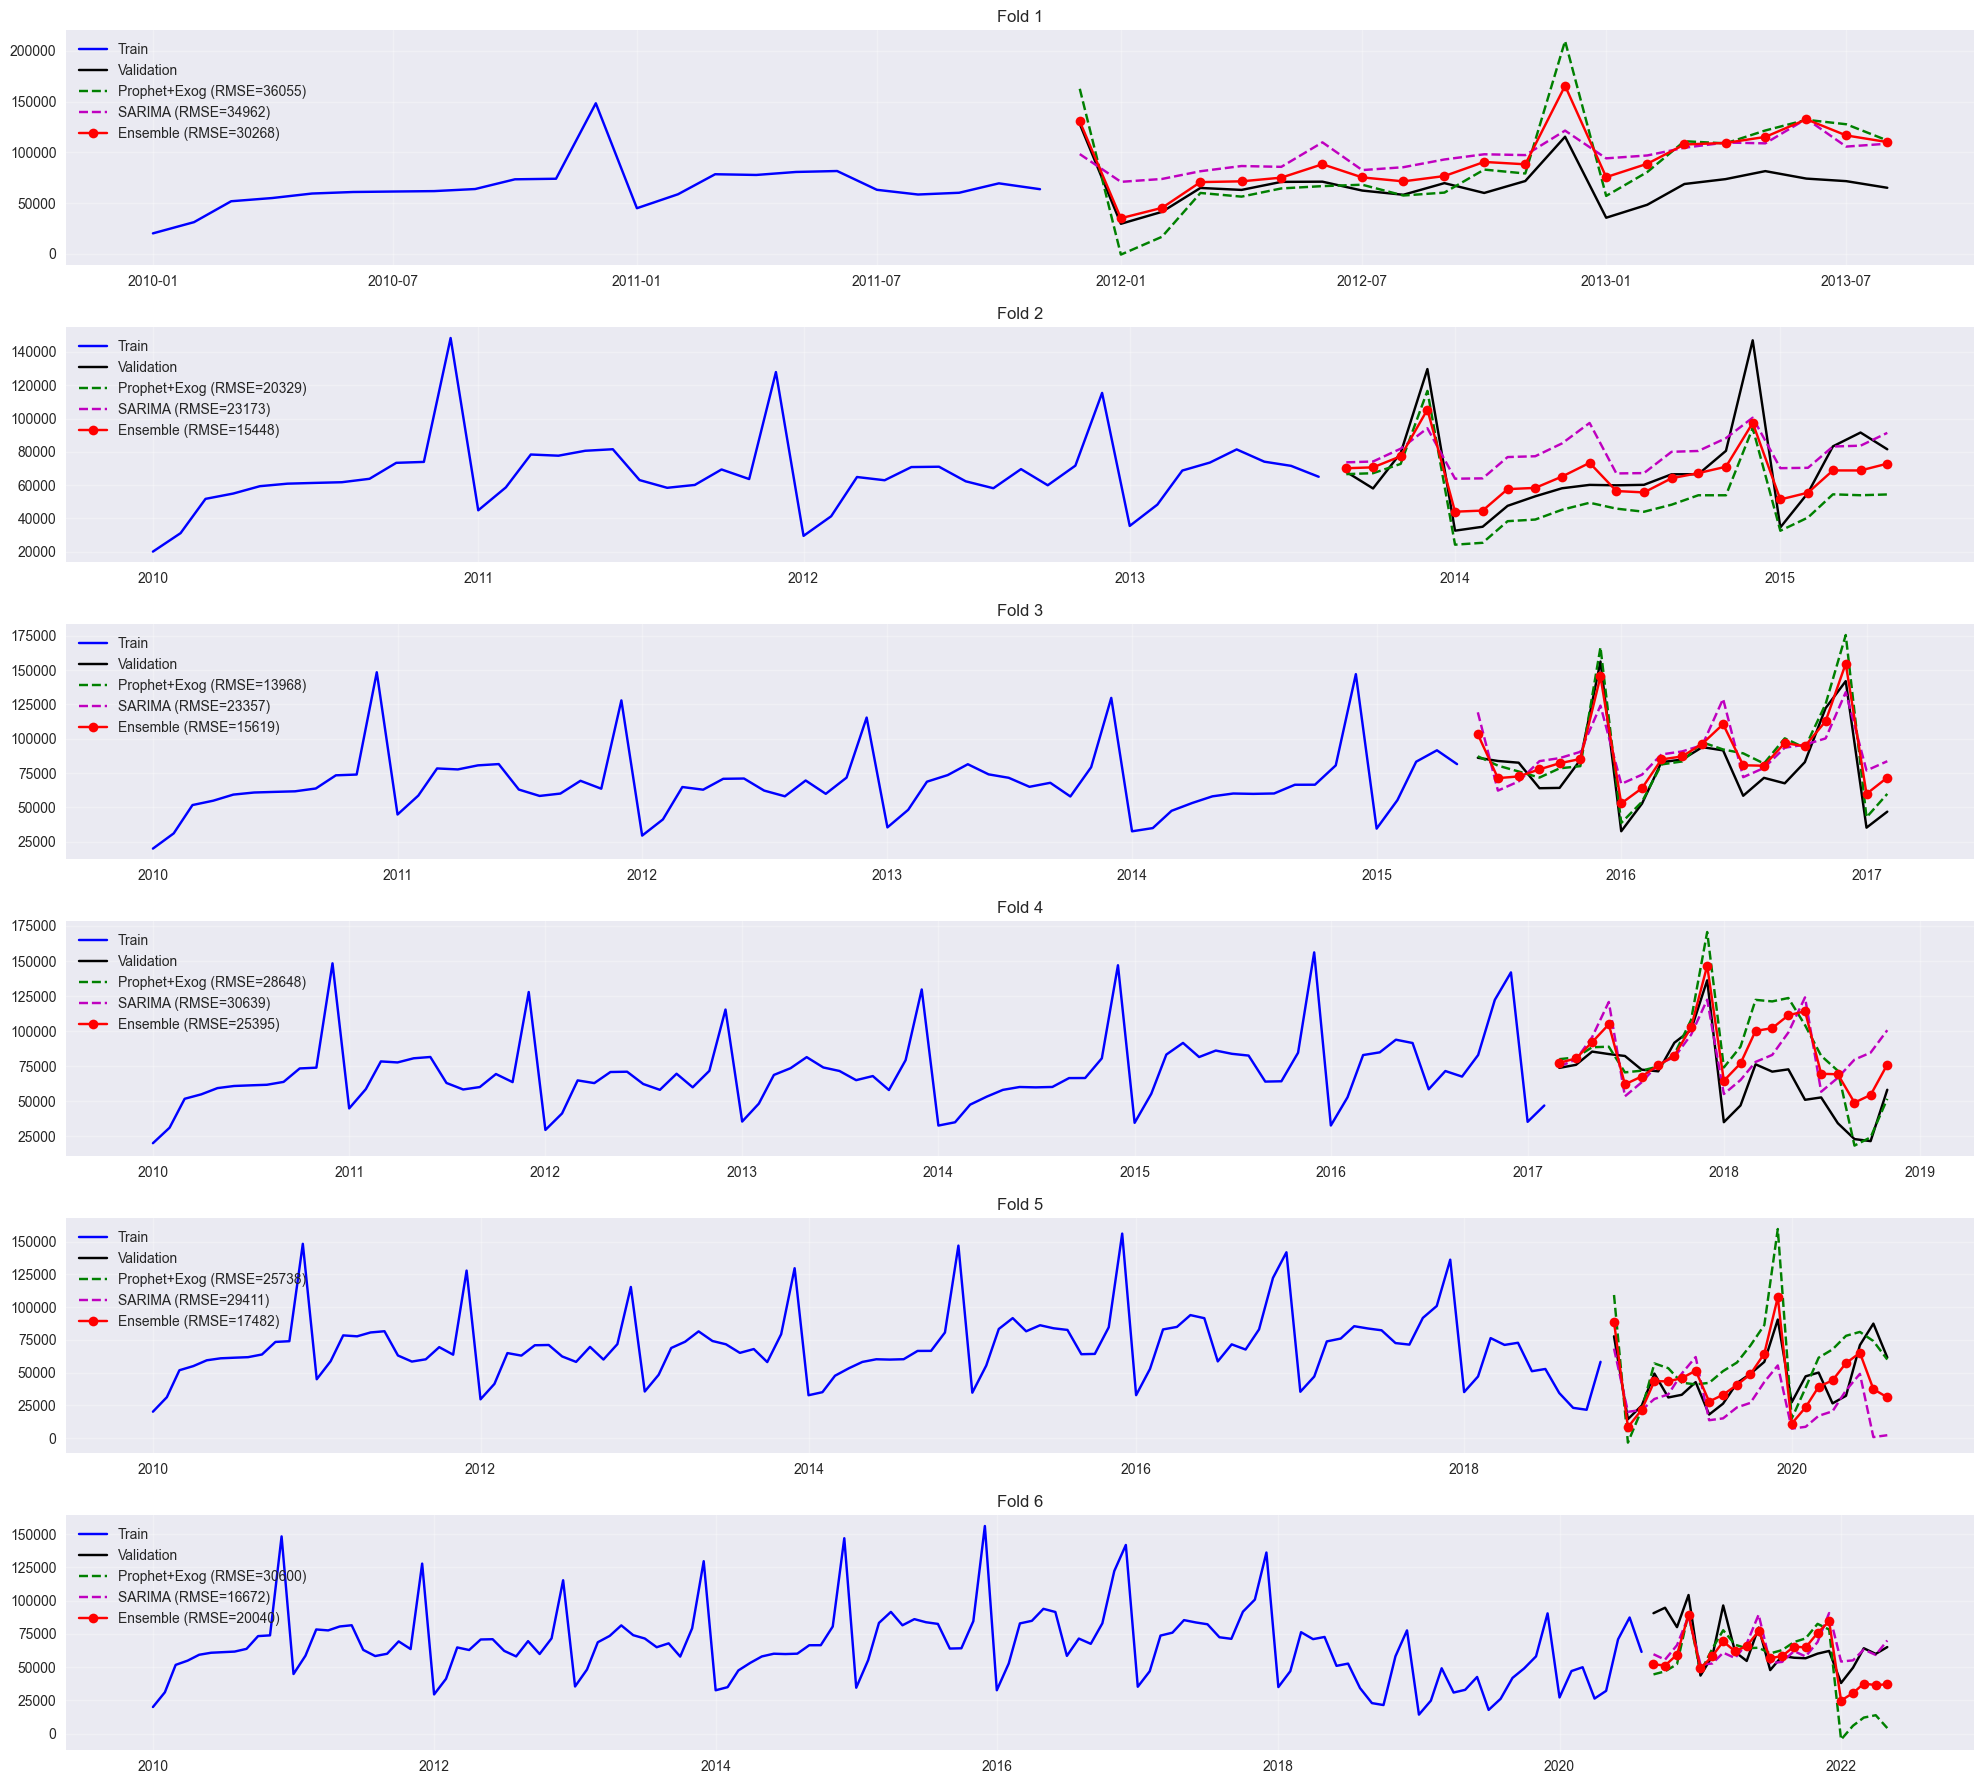

In [72]:
tscv = TimeSeriesSplit(n_splits=6)

rmse_prophet, rmse_sarima, rmse_ensemble = [], [], []
fold = 1
plt.figure(figsize=(20,18))

for train_idx, val_idx in tscv.split(y):
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    cd_train, cd_val = crisis_dummy.iloc[train_idx], crisis_dummy.iloc[val_idx]

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]

    # Prophet (exoglu)
    df_train_prophet = pd.DataFrame({
        "ds": y_train.index,
        "y": y_train.values,
        "crisis_dummy": cd_train.values
    })
    df_train_prophet = pd.concat([df_train_prophet, X_train.reset_index(drop=True)], axis=1)

    df_val_prophet = pd.DataFrame({
        "ds": y_val.index,
        "crisis_dummy": cd_val.values
    })
    df_val_prophet = pd.concat([df_val_prophet, X_val.reset_index(drop=True)], axis=1)

    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=1.0,
        seasonality_mode="multiplicative"
    )
    prophet_model.add_regressor("crisis_dummy")
    for var in exog_vars:
        prophet_model.add_regressor(var)
    prophet_model.fit(df_train_prophet)

    y_pred_prophet_raw = prophet_model.predict(df_val_prophet)["yhat"].values
    bias = np.mean(y_train.values - prophet_model.predict(df_train_prophet)["yhat"].values)
    y_pred_prophet = y_pred_prophet_raw + bias


    sarima_model = SARIMAX(
        endog=y_train,
        order=(0,1,1),
        seasonal_order=(0,1,1,6),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_res = sarima_model.fit(disp=False)
    y_pred_sarima = sarima_res.get_forecast(steps=len(y_val)).predicted_mean.values


    alpha = 0.5
    y_pred_ensemble = alpha * y_pred_prophet + (1 - alpha) * y_pred_sarima


    rmse_p = np.sqrt(mean_squared_error(y_val, y_pred_prophet))
    rmse_s = np.sqrt(mean_squared_error(y_val, y_pred_sarima))
    rmse_e = np.sqrt(mean_squared_error(y_val, y_pred_ensemble))

    rmse_prophet.append(rmse_p)
    rmse_sarima.append(rmse_s)
    rmse_ensemble.append(rmse_e)


    plt.subplot(6, 1, fold)
    plt.plot(y_train.index, y_train, label="Train", color="blue")
    plt.plot(y_val.index, y_val, label="Validation", color="black")
    plt.plot(y_val.index, y_pred_prophet, "g--", label=f"Prophet+Exog (RMSE={rmse_p:.0f})")
    plt.plot(y_val.index, y_pred_sarima, "m--", label=f"SARIMA (RMSE={rmse_s:.0f})")
    plt.plot(y_val.index, y_pred_ensemble, "r-o", label=f"Ensemble (RMSE={rmse_e:.0f})")
    plt.title(f"Fold {fold}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    fold += 1

plt.tight_layout()
plt.show()

In [73]:
print("Fold RMSE Prophet (exoglu):", rmse_prophet)
print("Fold RMSE SARIMA (exogsuz):", rmse_sarima)
print("Fold RMSE Ensemble:", rmse_ensemble)
print("\nMean RMSE Prophet:", np.mean(rmse_prophet))
print("Mean RMSE SARIMA:", np.mean(rmse_sarima))
print("Mean RMSE Ensemble:", np.mean(rmse_ensemble))




Fold RMSE Prophet (exoglu): [36055.36185856844, 20329.32717973597, 13967.724659733247, 28647.672560874544, 25737.565103367124, 30600.472748162734]
Fold RMSE SARIMA (exogsuz): [34962.31769404019, 23173.029964196496, 23356.694910859012, 30638.83577218491, 29410.751497865982, 16671.503092398205]
Fold RMSE Ensemble: [30268.000970131594, 15447.714610180825, 15618.960975556412, 25395.408772016784, 17482.3581885698, 20040.28855687115]

Mean RMSE Prophet: 25889.687351740344
Mean RMSE SARIMA: 26368.855488590798
Mean RMSE Ensemble: 20708.788678887762


15:50:40 - cmdstanpy - INFO - Chain [1] start processing
15:50:40 - cmdstanpy - INFO - Chain [1] done processing
d:\GIT\Linktera\linktera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

d:\GIT\Linktera\linktera\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



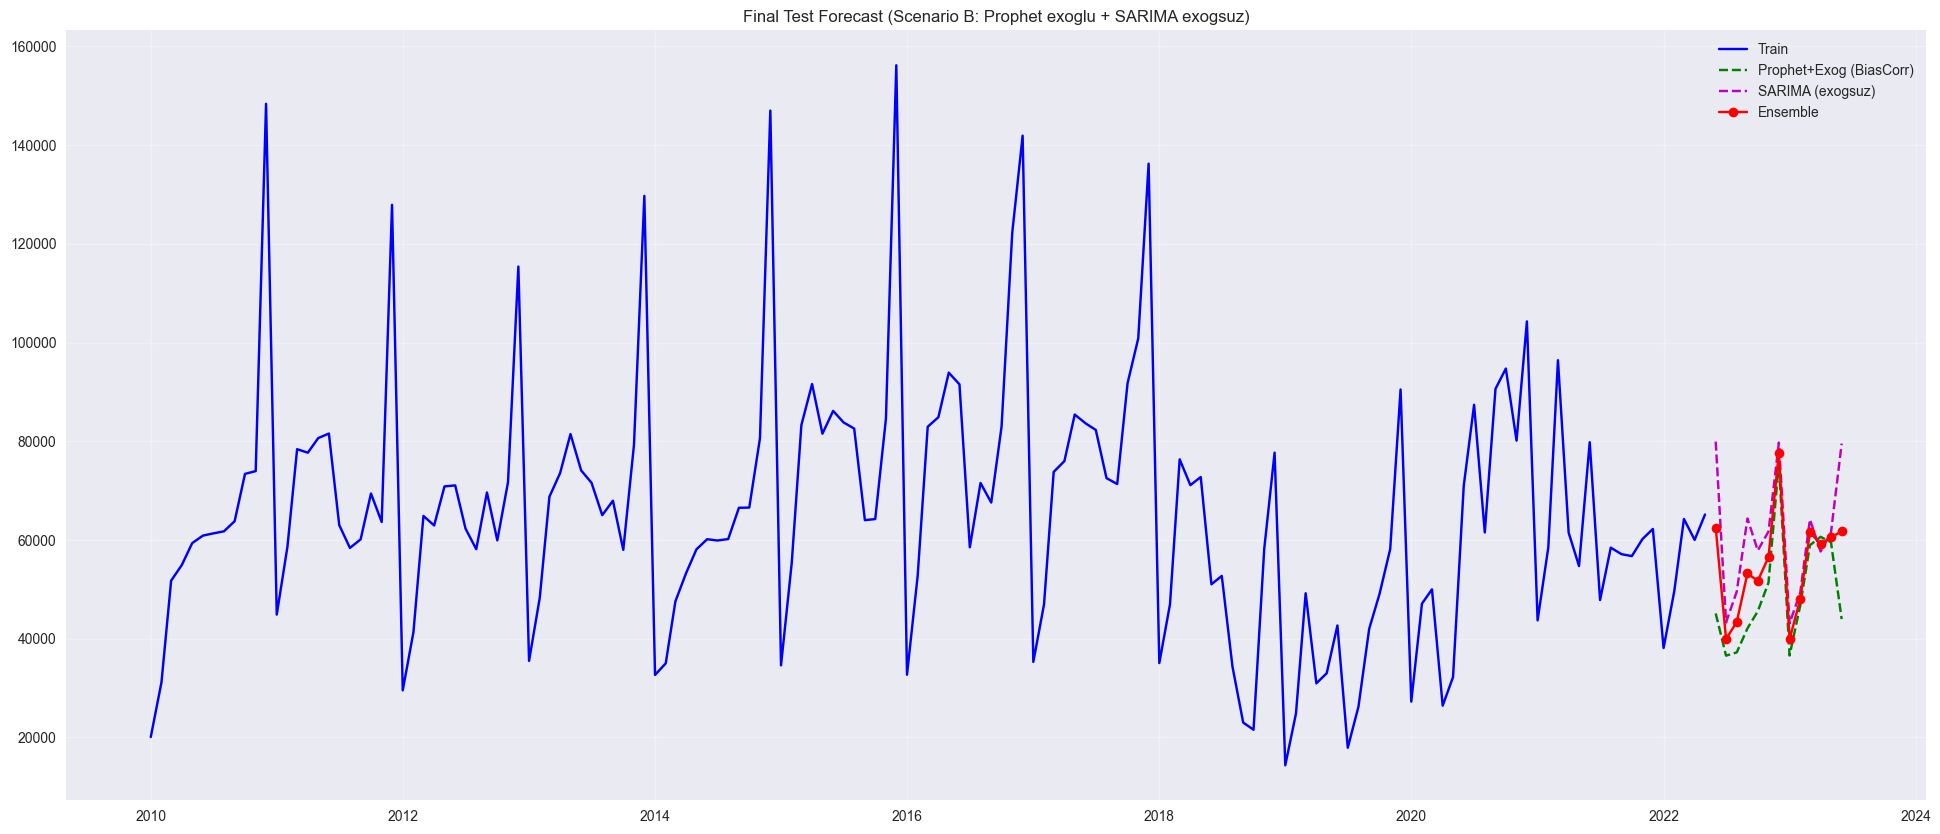

In [74]:

df_prophet_full = pd.DataFrame({
    "ds": train.index,
    "y": y.values,
    "crisis_dummy": crisis_dummy.values
})
df_prophet_full = pd.concat([df_prophet_full, X.reset_index(drop=True)], axis=1)

df_test_prophet = pd.DataFrame({
    "ds": test.index,
    "crisis_dummy": ((test.index >= "2018-01-01") & (test.index <= "2020-12-31")).astype(int)
})
df_test_prophet = pd.concat([df_test_prophet, X_test.reset_index(drop=True)], axis=1)

prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=5.0,
    seasonality_mode="multiplicative"
)
prophet_model.add_regressor("crisis_dummy")
for var in exog_vars:
    prophet_model.add_regressor(var)
prophet_model.fit(df_prophet_full)

yhat_train_full = prophet_model.predict(df_prophet_full)[["yhat"]].values
bias_full = np.mean(y.values - yhat_train_full.flatten())
forecast_prophet = prophet_model.predict(df_test_prophet)
y_pred_prophet_test = forecast_prophet["yhat"].values + bias_full


sarima_model_full = SARIMAX(
    endog=y,
    order=(0,1,1),
    seasonal_order=(0,1,1,6),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_res_full = sarima_model_full.fit(disp=False)
y_pred_sarima_test = sarima_res_full.get_forecast(steps=len(test)).predicted_mean.values


y_pred_ensemble_test = alpha * y_pred_prophet_test + (1 - alpha) * y_pred_sarima_test

plt.figure(figsize=(24, 10))
plt.plot(train.index, y, label="Train", color="blue")
plt.plot(test.index, y_pred_prophet_test, "g--", label="Prophet+Exog (BiasCorr)")
plt.plot(test.index, y_pred_sarima_test, "m--", label="SARIMA (exogsuz)")
plt.plot(test.index, y_pred_ensemble_test, "r-o", label="Ensemble")
plt.title("Final Test Forecast (Scenario B: Prophet exoglu + SARIMA exogsuz)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()                 

In [75]:
model_dir = "models/otomotiv_satis"
os.makedirs(model_dir, exist_ok=True)

In [76]:
joblib.dump(
    {"model": prophet_model, "bias": bias_full}, 
    os.path.join(model_dir, "prophet_model.pkl")
)


joblib.dump(
    sarima_res_full, 
    os.path.join(model_dir, "sarima_model.pkl")
)

['models/otomotiv_satis\\sarima_model.pkl']

In [77]:
np.save(os.path.join(model_dir, "y_pred_prophet_test.npy"), y_pred_prophet_test)
np.save(os.path.join(model_dir, "y_pred_sarima_test.npy"), y_pred_sarima_test)
np.save(os.path.join(model_dir, "y_pred_ensemble_test.npy"), y_pred_ensemble_test)

# Part 5 Model Load and Predict

You can directly run these 2 cells if you want to forecast with the saved model.

In [78]:
def prepare_features(df, target_col=None):
    df_out = df.copy()
    df_out = df_out.rename(columns={"Date": "ds"})
    if target_col is not None:
        df_out = df_out.rename(columns={target_col: "y"})

    df_out["crisis_dummy"] = ((df_out["ds"] >= "2018-01-01") & 
                              (df_out["ds"] <= "2020-12-31")).astype(int)

    for var in ["EUR/TL", "Faiz", "Kredi Stok", "OTV Orani"]:
        df_out[var] = df[var].values
    return df_out


train = pd.read_csv(r"data/final_data/train.csv")
train["Date"] = pd.to_datetime(train["Date"])
df_train = prepare_features(train, target_col="Otomotiv Satis")

test = pd.read_csv(r"data/final_data/test_filled.csv")
test["Date"] = pd.to_datetime(test["Date"])
df_test = prepare_features(test)


bundle = joblib.load("models/otomotiv_satis/prophet_model.pkl")
prophet_model, bias = bundle["model"], bundle["bias"]

sarima_model = joblib.load("models/otomotiv_satis/sarima_model.pkl")


forecast_prophet = prophet_model.predict(df_test)
forecast_prophet["yhat_bias_corrected"] = forecast_prophet["yhat"] + bias
forecast_prophet["yhat_lower_bias"] = forecast_prophet["yhat_lower"] + bias
forecast_prophet["yhat_upper_bias"] = forecast_prophet["yhat_upper"] + bias

sarima_forecast = sarima_model.get_forecast(steps=len(df_test))
yhat_sarima = sarima_forecast.predicted_mean.values


alpha = 0.5
yhat_ensemble = alpha * forecast_prophet["yhat_bias_corrected"].values + (1 - alpha) * yhat_sarima


fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df_train["ds"], y=df_train["y"],
    mode="lines",
    name="Train",
    line=dict(color="blue")
))


fig.add_trace(go.Scatter(
    x=df_test["ds"], y=forecast_prophet["yhat_bias_corrected"],
    mode="lines+markers",
    name="Prophet+Exog (Bias Corrected)",
    line=dict(color="green", dash="dot"),
    marker=dict(size=6)
))


fig.add_trace(go.Scatter(
    x=df_test["ds"], y=yhat_sarima,
    mode="lines+markers",
    name="SARIMA (Exogsuz)",
    line=dict(color="magenta", dash="dot"),
    marker=dict(size=6)
))


fig.add_trace(go.Scatter(
    x=df_test["ds"], y=yhat_ensemble,
    mode="lines+markers",
    name="Ensemble (Prophet+SARIMA)",
    line=dict(color="red"),
    marker=dict(size=6)
))


fig.add_trace(go.Scatter(
    x=list(df_test["ds"]) + list(df_test["ds"][::-1]),
    y=list(forecast_prophet["yhat_upper_bias"]) + list(forecast_prophet["yhat_lower_bias"][::-1]),
    fill="toself",
    fillcolor="rgba(0,200,0,0.2)",
    line=dict(color="rgba(255,255,255,0)"),
    hoverinfo="skip",
    name="Prophet Uncertainty Interval"
))

fig.update_layout(
    title="Otomotiv Satis Forecast (Scenario B: Prophet exoglu + SARIMA exogsuz)",
    xaxis_title="Date",
    yaxis_title="Otomotiv Satis",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

In [ ]:

mask_train_post2020 = df_train["ds"] >= "2020-01-01"
mask_test_post2020  = df_test["ds"] >= "2020-01-01"

df_train_post2020 = df_train.loc[mask_train_post2020]
df_test_post2020 = df_test.loc[mask_test_post2020]

prophet_post2020 = forecast_prophet.loc[mask_test_post2020]
sarima_post2020 = yhat_sarima[mask_test_post2020.values]
ensemble_post2020 = yhat_ensemble[mask_test_post2020.values]


fig = go.Figure()


fig.add_trace(go.Scatter(
    x=df_train_post2020["ds"], y=df_train_post2020["y"],
    mode="lines",
    name="Train (2020+)",
    line=dict(color="blue")
))


fig.add_trace(go.Scatter(
    x=df_test_post2020["ds"], y=prophet_post2020["yhat_bias_corrected"],
    mode="lines+markers",
    name="Prophet+Exog (Bias Corrected)",
    line=dict(color="green", dash="dot"),
    marker=dict(size=6)
))


fig.add_trace(go.Scatter(
    x=df_test_post2020["ds"], y=sarima_post2020,
    mode="lines+markers",
    name="SARIMA (Exogsuz)",
    line=dict(color="magenta", dash="dot"),
    marker=dict(size=6)
))

image.png
fig.add_trace(go.Scatter(
    x=df_test_post2020["ds"], y=ensemble_post2020,
    mode="lines+markers",
    name="Ensemble (Prophet+SARIMA)",
    line=dict(color="red"),
    marker=dict(size=6)
))


fig.add_trace(go.Scatter(
    x=list(df_test_post2020["ds"]) + list(df_test_post2020["ds"][::-1]),
    y=list(prophet_post2020["yhat_upper_bias"]) + list(prophet_post2020["yhat_lower_bias"][::-1]),
    fill="toself",
    fillcolor="rgba(0,200,0,0.2)",
    line=dict(color="rgba(255,255,255,0)"),
    hoverinfo="skip",
    name="Prophet Uncertainty Interval"
))

fig.update_layout(
    title="Otomotiv Satis Forecast (Scenario B: Prophet exoglu + SARIMA exogsuz, 2020+)",
    xaxis_title="Date",
    yaxis_title="Otomotiv Satis",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()
